<a href="https://colab.research.google.com/github/MichM072/ScriptieRec/blob/main/Scriptie_librec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Pip installations
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

local = os.path.isdir('data/movielens_100k/ml-100k/')

if local:
    path = 'data/movielens_100k/ml-100k/'
else:
    path = '/kaggle/input/movielens-100k-dataset/ml-100k/'
#     if not os.path.isdir('/content/drive/MyDrive/ml-100k/'):
#         from google.colab import drive
#         drive.mount('/content/drive')
#         path = '/content/drive/MyDrive/ml-100k/'

if not local:
  !pip install surprise
  !pip install LibRecommender
  !pip install ray -U "ray[tune]"

/kaggle/input/movielens-100k-dataset/ml-100k/u.occupation
/kaggle/input/movielens-100k-dataset/ml-100k/u1.base
/kaggle/input/movielens-100k-dataset/ml-100k/u.info
/kaggle/input/movielens-100k-dataset/ml-100k/u4.test
/kaggle/input/movielens-100k-dataset/ml-100k/u.item
/kaggle/input/movielens-100k-dataset/ml-100k/README
/kaggle/input/movielens-100k-dataset/ml-100k/u1.test
/kaggle/input/movielens-100k-dataset/ml-100k/ua.test
/kaggle/input/movielens-100k-dataset/ml-100k/u.data
/kaggle/input/movielens-100k-dataset/ml-100k/u5.test
/kaggle/input/movielens-100k-dataset/ml-100k/mku.sh
/kaggle/input/movielens-100k-dataset/ml-100k/u5.base
/kaggle/input/movielens-100k-dataset/ml-100k/u.user
/kaggle/input/movielens-100k-dataset/ml-100k/ub.base
/kaggle/input/movielens-100k-dataset/ml-100k/u4.base
/kaggle/input/movielens-100k-dataset/ml-100k/u2.test
/kaggle/input/movielens-100k-dataset/ml-100k/ua.base
/kaggle/input/movielens-100k-dataset/ml-100k/u3.test
/kaggle/input/movielens-100k-dataset/ml-100k/u.

In [2]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import gc
from surprise import Dataset
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.metrics import DistanceMetric
from sklearn import preprocessing
import tensorflow as tf

In [3]:
user_cols = ['userId',  'age',  'gender',  'occupation',  'zip code']
user_data = pd.read_csv(path + 'u.user', sep='|', names=user_cols)

rating_cols = ['userId' , 'itemId','rating', 'timestamp']
rating_matrix = pd.read_csv(path + 'u.data', sep='\t', names=rating_cols).sort_values(by='userId', ascending=True).reset_index(drop=True)

item_cols = ['itemId', 'movieTitle', 'releaseDate', 'videoReleaseDate', 
        'IMDb-URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Children\'s',
        'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
        'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
item_matrix = pd.read_csv(path + 'u.item', sep='|', names = item_cols, encoding = 'unicode_escape', engine ='python')

In [4]:
df_data = rating_matrix.merge(user_data, on='userId').merge(item_matrix, on='itemId')

df_data.head()

userId  itemId  rating  timestamp  age gender     occupation zip code  \
0       1      55       5  875072688   24      M     technician    85711   
1       8      55       5  879362286   36      M  administrator    05201   
2      16      55       5  877717956   21      M  entertainment    10309   
3      23      55       4  874785624   30      F         artist    48197   
4      24      55       5  875323308   21      F         artist    94533   

                 movieTitle  releaseDate  ...  Fantasy Film-Noir  Horror  \
0  Professional, The (1994)  01-Jan-1994  ...        0         0       0   
1  Professional, The (1994)  01-Jan-1994  ...        0         0       0   
2  Professional, The (1994)  01-Jan-1994  ...        0         0       0   
3  Professional, The (1994)  01-Jan-1994  ...        0         0       0   
4  Professional, The (1994)  01-Jan-1994  ...        0         0       0   

   Musical  Mystery  Romance  Sci-Fi  Thriller  War  Western  
0        0        0        1       0         1    0        0  
1        0        0        1       0         1    0        0  
2        0        0        1       0         1    0        0  
3        0        0        1       0         1    0        0  
4        0        0        1       0         1    0        0  

[5 rows x 31 columns]

In [5]:
day_split = 86400

from libreco.data import random_split

df_data = df_data.rename(columns = {'userId': 'user', 'itemId' : 'item', 'rating': 'label', 'timestamp': 'time'})

# df_data2

# split data into three folds for training, evaluating and testing
# first_half_data = df_data[: (len(df_data) // 2)]
train_data, eval_data, test_data = random_split(df_data, multi_ratios=[0.8, 0.1, 0.1], seed=42)

In [6]:
from libreco.data import DatasetPure

# sparse_col = ["gender", "occupation", "zip code", 
#               'unknown', 'Action', 'Adventure', 'Animation', 'Children\'s',
#               'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
#               'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
# dense_col = ["age"]
# user_col = ['age', 'gender', 'occupation', 'zip code']
# item_col = ['unknown', 'Action', 'Adventure', 'Animation', 'Children\'s',
#               'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
#               'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

train_data, data_info = DatasetPure.build_trainset(train_data)
eval_data = DatasetPure.build_evalset(eval_data)
test_data = DatasetPure.build_testset(test_data)

In [7]:
from libreco.algorithms import SVD
from libreco.evaluation import evaluate

In [8]:
# import itertools

# test_grid = {
#     'epochs' : [10, 20, 30],
#     'reg' : [2, 4]
# }

# # print(list(test_grid.keys()))
# # allNames = sorted(test_grid)
# # print(allNames)
# # combinations = itertools.product(*(test_grid[Name] for Name in allNames))
# # print(list(combinations))

# keys, values = zip(*test_grid.items())
# permutations_dicts = [dict(zip(keys, v)) for v in itertools.product(*values)]

# for combination in permutations_dicts:
#   for key in combination:
#     print(combination[key])
#   print(combination)

In [9]:
# import copy

# def gridsearch(model, param_grid, **kwargs):

#   target_model = model

#   best_config = []
#   best_eval = 1000

#   keys, values = zip(*param_grid.items())
#   combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

#   for configuration in combinations:

#     # reset graph
#     tf.compat.v1.reset_default_graph()

#     # Initialize estimator model
#     est = target_model(**kwargs)

#     pre_reg_conf = copy.copy(configuration)

#     for attribute in configuration:
#       if attribute == 'reg' and attribute is not None:
#         configuration[attribute] = tf.keras.regularizers.l2(configuration[attribute])
#       setattr(est, attribute, configuration[attribute])

#     print(f'Configuration completed, training: {target_model.__name__}')
#     print(f'Current configuration: {pre_reg_conf}')

#     with tf.device('/GPU:0'):

#       est.fit(
#           train_data,
#           verbose=0,
#           shuffle=True,
#       )

#     evaluation = evaluate(model=est, data=eval_data, metrics=["rmse"])
#     if evaluation['rmse'] < best_eval:
#       best_eval = evaluation['rmse']
#       best_config = configuration

#   return (best_config, best_eval)

In [10]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [11]:
# tf.compat.v1.reset_default_graph()

# param_grid = {
#     'n_epochs': [10],
#     'reg': [0.2],
#     'lr': [0.004],
#     'embed_size': [10, 100]
# }

# defaults = {'task': 'ranking',
#             'data_info':data_info, 
#             'loss_type': "cross_entropy", 
#             'lr':1e-04, 
#             'batch_size':2048}

# gridsearch(SVD, param_grid, task="rating",
#     data_info=data_info,
#     loss_type="cross_entropy",
#     lr=1e-3,
#     batch_size=2048)

In [12]:
# for reg in [None, 0.000002, 0.00002, 0.0002, 0.002, 0.02]:
#   tf.compat.v1.reset_default_graph()
#   model = SVD(
#     task="rating",
#     data_info=data_info,
#     n_epochs=1,
#     loss_type="cross_entropy",
#     lr=0.03,
#     reg=reg,
#     batch_size=2048,
# )
#   model.fit(
#       train_data,
#       verbose=2,
#       shuffle=True,
#       eval_data=eval_data,
#       metrics=['rmse'],
#   )

In [13]:
# tf.compat.v1.reset_default_graph()

# model = SVD(
#     task="rating",
#     data_info=data_info,
#     embed_size = 100,
#     n_epochs=20,
#     loss_type="cross_entropy",
#     lr = 0.001,
#     reg = 0.02,
#     batch_size=2048,
# )

# model.fit(
#     train_data,
#     verbose=0,
#     shuffle=True,
#     eval_data=eval_data,
#     metrics=["msre"],
# )

# model.get_item_embedding(1)

In [14]:
from libreco.evaluation import evaluate
# evaluate(model=model, data=test_data, metrics=['rmse'])

In [15]:
from libreco.algorithms import (
    ALS,
    SVD,
    ItemCF,
    SVDpp,
    UserCF,
)

In [16]:
# def create_regs(regs):
#   regulators = [tf.keras.regularizers.l2(reg) for reg in regs]
#   regulators.append(None)
#   return regulators

In [17]:
!pip install hpbandster ConfigSpace
!pip install statsmodels --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 46.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/90.0 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 kB 5.3 MB/s eta 0:00:00
  Created wheel for hpbandster: filename=hpbandster-0.7.4-py3-none-any.whl size=80008 sha256=2047dde74f15b9bc0bf43df670599b84a7db2fc034c31afcd842a46638ff4ae0
  Stored in directory: /root/.cache/pip/wheels/59/5d/ae/de6975c9d67f502599f0a1ba89d0794c8692d0e73a57f2a3ea
Successfully built hpbandster


In [18]:
from ray import tune, air
from ray.tune.search.hyperopt import HyperOptSearch
from ray.tune.schedulers.hb_bohb import HyperBandForBOHB
from ray.tune.search.bohb import TuneBOHB
from ray.air import session
import ConfigSpace as CS

In [19]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

# Hyper parameter optimalisation!

In [20]:
from IPython.display import clear_output

In [21]:
def svd_tuner(train_data, eval_data, data_info, search_space, samples=10):
    def objective(config):
      tf.compat.v1.reset_default_graph()
      svd = SVD(
          "rating",
          data_info,
          loss_type="cross_entropy",
          embed_size=config['embed_size'],
          n_epochs=config['n_epochs'],
          lr=config['lr'],
          reg=config['reg'],
          batch_size=256,
      )
      svd.fit(
        train_data,
        verbose=0,
        shuffle=False,
        neg_sampling=False,
      )
      clear_output(wait=False)
      accuracy = evaluate(model=svd, data=eval_data, metrics=['rmse'], neg_sampling=False)
      acc = accuracy['rmse']
      return {"rmse": acc}

    search_space = search_space

    Bhob = TuneBOHB()
    Bhob = tune.search.ConcurrencyLimiter(Bhob, max_concurrent=4)
    scheduler = HyperBandForBOHB(
        time_attr="training_iteration",
        max_t=100,
        reduction_factor=4,
        stop_last_trials=False,
    )

    svd_tuner = tune.Tuner(
        tune.with_resources(
            objective, resources={"cpu": 2, "gpu": 0.5, "accelator": 1}
        ),
        # objective,
        tune_config=tune.TuneConfig(
            metric="rmse",
            mode="min",
            search_alg=Bhob,
            num_samples=samples,
            scheduler=scheduler,
        ),
            run_config=air.RunConfig(
            name="bohb_exp",
            stop={"training_iteration": 100},
        ),
        param_space=search_space,
    )
    result = svd_tuner.fit()
    return result.get_best_result().config

In [22]:
# svd_search = {'n_epochs': tune.choice([10, 25, 50, 75, 100]),
#         'lr': tune.choice([1e-3, 2e-3, 3e-3, 4e-3]),
#         'reg': tune.choice([1e-4, 2e-4, 3e-4]),
#         'embed_size': tune.choice([10, 20, 50, 75, 100])}

# very_nice_test_run = svd_tuner(train_data, eval_data, data_info, svd_search)

In [23]:
# print(very_nice_test_run.get_best_result().config)

In [24]:
# svd_tuner.get_results().get_best_result()

In [25]:
def svdpp_tuner(train_data, eval_data, data_info, search_space, samples=10):
    def objective(config):
      tf.compat.v1.reset_default_graph()
      svdpp = SVDpp(
          "rating",
          data_info,
          loss_type="cross_entropy",
          embed_size=config['embed_size'],
          n_epochs=config['n_epochs'],
          lr=config['lr'],
          reg=config['reg'],
          batch_size=256,
      )
      svdpp.fit(
        train_data,
        verbose=0,
        shuffle=False,
        neg_sampling=False,
      )
      clear_output(wait=False)
      accuracy = evaluate(model=svdpp, data=eval_data, metrics=['rmse'], neg_sampling=False)
      acc = accuracy['rmse']
      return {"rmse": acc}

    search_space = search_space

    Bhob = TuneBOHB()
    Bhob = tune.search.ConcurrencyLimiter(Bhob, max_concurrent=2)
    scheduler = HyperBandForBOHB(
        time_attr="training_iteration",
        max_t=100,
        reduction_factor=4,
        stop_last_trials=False,
    )

    svdpp_tuner = tune.Tuner(
        tune.with_resources(
            objective, resources={"cpu": 2, "gpu": 0.5}
        ),
        # objective,
        tune_config=tune.TuneConfig(
            metric="rmse",
            mode="min",
            search_alg=Bhob,
            num_samples=samples,
            scheduler=scheduler,
        ),
            run_config=air.RunConfig(
            name="bohb_exp",
            stop={"training_iteration": 100},
        ),
        param_space=search_space,
    )
    return svdpp_tuner.fit().get_best_result().config

In [26]:
# svdpp_search = {'n_epochs': tune.choice([10, 25, 50, 75, 100]),
#         'lr': tune.choice([1e-3, 2e-3, 3e-3, 4e-3]),
#         'reg': tune.choice([1e-4, 2e-4, 3e-4]),
#         'embed_size': tune.choice([10, 20, 50, 75, 100])}

# very_nice_test_run2 = svdpp_tuner(train_data, eval_data, data_info, svdpp_search)

In [27]:
# svdpp_tuner.get_results().get_best_result()

In [28]:
def als_tuner(train_data, eval_data, data_info, search_space, samples=10):
    def objective(config):
      tf.compat.v1.reset_default_graph()
      als = ALS(
          "rating",
          data_info,
          embed_size=config['embed_size'],
          n_epochs=config['n_epochs'],
          reg=config['reg'],
      )
      als.fit(
        train_data,
        verbose=0,
        shuffle=False,
        neg_sampling=False,
      )
      clear_output(wait=False)
      accuracy = evaluate(model=als, data=eval_data, metrics=['rmse'], neg_sampling=False)
      acc = accuracy['rmse']
      return {"rmse": acc}

    search_space = search_space

    Bhob = TuneBOHB()
    Bhob = tune.search.ConcurrencyLimiter(Bhob, max_concurrent=4)
    scheduler = HyperBandForBOHB(
        time_attr="training_iteration",
        max_t=100,
        reduction_factor=4,
        stop_last_trials=False,
    )

    als_tuner = tune.Tuner(
        tune.with_resources(
            objective, resources={"cpu": 2, "gpu": 0.5}
        ),
        # objective,
        tune_config=tune.TuneConfig(
            metric="rmse",
            mode="min",
            search_alg=Bhob,
            num_samples=samples,
            scheduler=scheduler,
        ),
            run_config=air.RunConfig(
            name="bohb_exp",
            stop={"training_iteration": 100},
        ),
        param_space=search_space,
    )
    return als_tuner.fit().get_best_result().config

In [29]:
# als_tuner.get_results().get_best_result()

In [30]:
# tf.compat.v1.reset_default_graph()
# als = ALS(
#     "rating",
#     data_info,
#     embed_size=10,
#     n_epochs=100,
#     reg=5.0,
# )
# als.fit(
#   train_data,
#   verbose=2,
#   shuffle=True,
# )
# accuracy = evaluate(model=als, data=eval_data, metrics=['rmse'])

# print(accuracy)

In [31]:
# tf.compat.v1.reset_default_graph()
# user_cf = UserCF(
#     "rating",
#     data_info,
#     sim_type='cosine',
#     k_sim=25,
# )
# user_cf.fit(
#   train_data,
#   verbose=0,
# )
# accuracy = evaluate(model=user_cf, data=eval_data, metrics=['rmse'])
# acc = accuracy['rmse']

In [32]:
# print(acc)

In [33]:
def item_cf_tuner(train_data, eval_data, data_info, search_space, samples=10):
    def objective(config):
      tf.compat.v1.reset_default_graph()
      item_cf = ItemCF(
          "rating",
          data_info,
          sim_type=config['sim_type'],
          k_sim=config['k_sim'],
      )
      item_cf.fit(
        train_data,
        verbose=0,
        neg_sampling=False,
      )
      accuracy = evaluate(model=item_cf, data=eval_data, metrics=['rmse'], neg_sampling=False)
      acc = accuracy['rmse']
      return {"rmse": acc}

    search_space = search_space

    Bhob = TuneBOHB()
    Bhob = tune.search.ConcurrencyLimiter(Bhob, max_concurrent=4)
    scheduler = HyperBandForBOHB(
        time_attr="training_iteration",
        max_t=100,
        reduction_factor=4,
        stop_last_trials=False,
    )

    item_cf_tuner = tune.Tuner(
        tune.with_resources(
            objective, resources={"cpu": 2, "gpu": 0.5}
        ),
        # objective,
        tune_config=tune.TuneConfig(
            metric="rmse",
            mode="min",
            search_alg=Bhob,
            num_samples=samples,
            scheduler=scheduler,
        ),
            run_config=air.RunConfig(
            name="bohb_exp",
            stop={"training_iteration": 100},
        ),
        param_space=search_space,
    )
    return item_cf_tuner.fit().get_best_result().config

In [34]:
# print("Best hyperparameters found were: ", item_cf_results.get_best_result().config)
# item_cf_tuner.get_results().get_best_result()

In [35]:
def user_cf_tuner(train_data, eval_data, data_info, search_space, samples=10):
    def objective(config):
      tf.compat.v1.reset_default_graph()
      user_cf = UserCF(
          "rating",
          data_info,
          sim_type=config['sim_type'],
          k_sim=config['k_sim'],
      )
      user_cf.fit(
        train_data,
        verbose=0,
        neg_sampling=False,
      )
      accuracy = evaluate(model=user_cf, data=eval_data, metrics=['rmse'], neg_sampling=False)
      acc = accuracy['rmse']
      return {"rmse": acc}

    search_space = search_space

    Bhob = TuneBOHB()
    Bhob = tune.search.ConcurrencyLimiter(Bhob, max_concurrent=4)
    scheduler = HyperBandForBOHB(
        time_attr="training_iteration",
        max_t=100,
        reduction_factor=4,
        stop_last_trials=False,
    )

    user_cf_tuner = tune.Tuner(
        tune.with_resources(
            objective, resources={"cpu": 2, "gpu": 0.5}
        ),
        # objective,
        tune_config=tune.TuneConfig(
            metric="rmse",
            mode="min",
            search_alg=Bhob,
            num_samples=samples,
            scheduler=scheduler,
        ),
            run_config=air.RunConfig(
            name="bohb_exp",
            stop={"training_iteration": 100},
        ),
        param_space=search_space,
    )
    return user_cf_tuner.fit().get_best_result().config

In [36]:
# print("Best hyperparameters found were: ", user_cf_results.get_best_result().config)
# user_cf_tuner.get_results().get_best_result()

In [37]:
# tf.compat.v1.reset_default_graph()

# model_1 = ALS(
#     task="rating",
#     data_info=data_info,
#     embed_size = 10,
#     n_epochs=200,
#     reg = 7.0,
#     lower_upper_bound = (0,5)
# )

# model_1.fit(
#     train_data,
#     verbose=0,
#     shuffle=False,
#     eval_data=eval_data,
#     metrics=["msre"],
# )

# accuracy_m1 = evaluate(model=model_1, data=test_data, metrics=['rmse'])

In [38]:
# tf.compat.v1.reset_default_graph()

# model_2 = ALS(
#     task="rating",
#     data_info=data_info,
#     embed_size = 10,
#     n_epochs=200,
#     reg = 7.0,
# )

# model_2.fit(
#     train_data,
#     verbose=0,
#     shuffle=False,
#     eval_data=eval_data,
#     metrics=["msre"],
# )
# accuracy_m2 = evaluate(model=model_2, data=test_data, metrics=['rmse'])

In [39]:
# print(accuracy_m1, accuracy_m2)

In [40]:
# !zip -r root.zip /root/ 

In [41]:
# def objective(config):
#   tf.compat.v1.reset_default_graph()
#   svdpp = SVDpp(
#       "rating",
#       data_info,
#       loss_type="cross_entropy",
#       embed_size=config['embed_size'],
#       n_epochs=config['n_epochs'],
#       lr=config['lr'],
#       reg=config['reg'],
#       batch_size=256,
#   )
#   svdpp.fit(
#     train_data,
#     verbose=2,
#     shuffle=True,
#   )
#   accuracy = evaluate(model=svdpp, data=eval_data, metrics=['rmse'])
#   acc = accuracy['rmse']
#   return {"rmse": acc}

# search_space = {'n_epochs': tune.choice([10, 25, 50, 75, 100]),
#     'lr': tune.choice([1e-3, 2e-3, 3e-3, 4e-3]),
#     'reg': tune.choice([None, 1e-4, 2e-4, 3e-4]),
#     'embed_size': tune.choice([10, 20, 50, 75, 100])}

# algo = HyperOptSearch()

# svdpp_tuner = tune.Tuner(
#     objective,
#     tune_config=tune.TuneConfig(
#         metric="rmse",
#         mode="min",
#         search_alg=algo,
#         num_samples=20,
#     ),
#     param_space=search_space,
# )
# results = svdpp_tuner.fit()

In [42]:
# svdpp_tuner.get_results().get_best_result()

In [43]:
# tf.compat.v1.reset_default_graph()

# param_grid = {
#     'n_epochs': [10, 25, 50, 75, 100],
#     'lr': [1e-3, 2e-3, 3e-3, 4e-3],
#     'regs': [0.03, 0.04, 0.05],
#     'embed_size': [10, 20, 50, 75, 100]
# }

# param_grid2 = {
#     'n_epochs': [10, 25, 50],
#     'lr': [1e-3, 2e-3, 3e-3, 4e-3],
#     'regs': [0.03, 0.04, 0.05],
#     'embed_size': [10, 20, 50, 75, 100]
# }

# defaults = {'task': 'rating',
#             'data_info':data_info, 
#             'loss_type': "cross_entropy", 
#             'lr':1e-04, 
#             'batch_size':2048}

# performance = []


# config, eval = gridsearch(SVD, param_grid, task="rating",
#       data_info=data_info)
# print(f'Finished {model}')
# result = ('SVD', config, eval)
# performance.append(result)
# print('Fully finished!')

In [44]:
# print(performance)

In [45]:
df_data.head()

user  item  label       time  age gender     occupation zip code  \
0     1    55      5  875072688   24      M     technician    85711   
1     8    55      5  879362286   36      M  administrator    05201   
2    16    55      5  877717956   21      M  entertainment    10309   
3    23    55      4  874785624   30      F         artist    48197   
4    24    55      5  875323308   21      F         artist    94533   

                 movieTitle  releaseDate  ...  Fantasy Film-Noir  Horror  \
0  Professional, The (1994)  01-Jan-1994  ...        0         0       0   
1  Professional, The (1994)  01-Jan-1994  ...        0         0       0   
2  Professional, The (1994)  01-Jan-1994  ...        0         0       0   
3  Professional, The (1994)  01-Jan-1994  ...        0         0       0   
4  Professional, The (1994)  01-Jan-1994  ...        0         0       0   

   Musical  Mystery  Romance  Sci-Fi  Thriller  War  Western  
0        0        0        1       0         1    0        0  
1        0        0        1       0         1    0        0  
2        0        0        1       0         1    0        0  
3        0        0        1       0         1    0        0  
4        0        0        1       0         1    0        0  

[5 rows x 31 columns]

In [46]:
from libreco.data import split_by_num_chrono

def create_timesets(data, increments = 1, test_num = 1, stop = None, ignore_remainder = True):

  train_days = df_data.time.min()
  day_split = 86400 # day in seconds
  train_sets = [] # list of train_set datasets
  test_sets = [] # list of test_sets
  temporal_data = [] # keep track of how many days have been trained on.

  if stop == None:
    stop = df_data.time.max()
  else:
    stop = train_days + day_split * increments * stop

  while train_days < stop:
    train_days = train_days + day_split * increments

    temp_data = data.loc[data['time'] <= train_days]

    train_set, test_set = split_by_num_chrono(temp_data, test_size=test_num)

#     test_set = test_set.loc[test_set['user'].isin(train_set['user'])]
#     train_set = train_set.loc[train_set['user'].isin(test_set['user'])]

    train_sets.append(train_set)
    test_sets.append(test_set)

    temp_time = train_days - df_data.time.min()
    temporal_data.append(temp_time)

  return train_sets, test_sets, temporal_data

In [47]:
train, test, temppp = create_timesets(df_data, increments=10, test_num = 1, stop = 4)

print(train[3]['user'].isin(test[3]['user']).value_counts())

True     16041
False      472
Name: user, dtype: int64


In [48]:
def create_timesets2(data, increments = 1, test_days = 1, stop = None, ignore_remainder = True):

  train_days = df_data.time.min()
  day_split = 86400 # day in seconds
  train_sets = [] # list of train_set datasets
  test_sets = [] # list of test_sets
  temporal_data = [] # keep track of how many days have been trained on.

  if stop == None:
    stop = df_data.time.max()
  else:
    stop = train_days + day_split * increments * stop

  while train_days < stop:
    train_days = train_days + day_split * increments

    train_set = data.loc[data['time'] <= train_days]
    test_set = data.loc[(data['time'] > train_days) & (data['time'] <= train_days + day_split * test_days)]

    test_set = test_set.loc[test_set['user'].isin(train_set['user'])]
    train_set = train_set.loc[train_set['user'].isin(test_set['user'])]

    train_sets.append(train_set)
    test_sets.append(test_set)

    temp_time = train_days - df_data.time.min()
    temporal_data.append(temp_time)

  return train_sets, test_sets, temporal_data

In [49]:
from libreco.data import split_by_ratio_chrono
def create_timesets3(data, increments = 1, test_days = 1, stop = None, ignore_remainder = True, make_eval=False, eval_size=0.2):

    train_days = df_data.time.min()
    day_split = 86400 # day in seconds
    train_sets = [] # list of train_set datasets
    test_sets = [] # list of test_sets
    eval_sets = []
    temporal_data = [] # keep track of how many days have been trained on.

    if stop == None:
        stop = df_data.time.max()
    else:
        stop = train_days + day_split * increments * stop

    while train_days + day_split * (increments + test_days) <= stop:
        train_days = train_days + day_split * increments

        test_set = data.loc[(data['time'] <= train_days + day_split * test_days) & (data['time'] > train_days)]
        train_set = data.loc[data['time'] <= train_days]

        if make_eval:
            train_set, eval_set = split_by_ratio_chrono(train_set, test_size = eval_size)
            eval_sets.append(eval_set)

        test_set = test_set.loc[(test_set['user'].isin(train_set['user'])) & (test_set['item'].isin(train_set['item']))]

        train_sets.append(train_set)
        test_sets.append(test_set)

        temp_time = train_days - df_data.time.min()
        temporal_data.append(temp_time)
    
    if make_eval:
        return train_sets, test_sets, eval_sets, temporal_data
    
    return train_sets, test_sets, temporal_data

In [50]:
# from libreco.data import split_by_ratio_chrono
# def make_chrono_split(data, increments = 1, test_days = 1, stop = None, ignore_remainder = True, make_eval=False, eval_size=0.2):

#     train_days = df_data.time.min()
#     day_split = 86400 # day in seconds
#     train_sets = [] # list of train_set datasets
#     test_sets = [] # list of test_sets
#     eval_sets = []
#     temporal_data = [] # keep track of how many days have been trained on.

#     if stop == None:
#         stop = df_data.time.max()
#     else:
#         stop = train_days + day_split * increments * stop

#     while train_days + day_split * (increments + test_days) <= stop:
#         train_days = train_days + day_split * increments

#         test_set = data.loc[(data['time'] <= train_days + day_split * test_days) & (data['time'] > train_days)]
#         train_set = data.loc[data['time'] <= train_days]

#         if make_eval:
#             train_set, eval_set = split_by_ratio_chrono(train_set, test_size = eval_size)
#             eval_sets.append(eval_set)

#         test_set = test_set.loc[(test_set['user'].isin(train_set['user'])) & (test_set['item'].isin(train_set['item']))]

#         train_sets.append(train_set)
#         test_sets.append(test_set)

#         temp_time = train_days - df_data.time.min()
#         temporal_data.append(temp_time)
    
#     if make_eval:
#         return train_sets, test_sets, eval_sets, temporal_data
    
#     return train_sets, test_sets, temporal_data

In [51]:
# train, test, temppp = create_timesets3(df_data, increments=10, test_days = 1, stop = 4)

# print(test[3]['user'].isin(train[3]['user']).value_counts())

In [52]:
# accuracy = []
# epochs = []

# for epoch in [10, 15, 25, 50, 75, 100]:
#     epochs.append(epoch)
#     tf.compat.v1.reset_default_graph()
#     svdpp = SVDpp(
#           "rating",
#           data_info,
#           loss_type="cross_entropy",
#           embed_size=20,
#           n_epochs=epoch,
#           lr=0.0001,
#           reg=0.01,
#           batch_size=256,
#       )
#     svdpp.fit(
#         train_data,
#         verbose=-1,
#         shuffle=False,
#       )
    
#     accuracy.append(evaluate(model=svdpp, data=eval_data, metrics=['rmse'])['rmse'])

# fig, ax = plt.subplots()

# ax.plot(epochs, accuracy, label=f'{epoch}')

# ax.set(xlabel=f'epoch {epoch}', ylabel=f'accuracy',
#       title=f'Comparison for {epoch}')
# ax.grid()
# #     ax.set_xticks(ax.get_xticks()[::])

# # fig.savefig("test.png")
# plt.legend()
# plt.show()

In [53]:
# accuracy = evaluate(model=svdpp, data=eval_data, metrics=['rmse'])

# accuracy.values()

In [54]:
# total_precision = 0

# for user in np.unique(test_data.user_indices):
#     print(user)
    

In [55]:
# train, test, temppp = create_timesets(df_data, increments=10, test_num = 1, stop = 5)

# for temp in temppp:
#   print(temp / 86400)

In [56]:
# for tr, te in zip(train, test):
#   print(tr.shape)
#   print(te.shape)

In [57]:
# kaas1, kaas2 = split_by_num_chrono(df_data, test_size = 1)
# kaas1, data_kaas = DatasetPure.build_trainset(kaas1)
# kaas2 = DatasetPure.build_testset(kaas2)

# for user in kaas1.user_indices:
#   if user not in kaas2.user_indices:
#     print(user)

In [58]:
import matplotlib.pyplot as plt

In [59]:
test = {'Day 1': {'SVD': {'precision': 0.09759825327510918, 'recall': 0.11243680555691093, 'map': 0.2329821183082646, 'ndcg': 0.32328197069467746}, 'SVDpp': {'precision': 0.09574235807860262, 'recall': 0.11352322985020856, 'map': 0.23240755181257364, 'ndcg': 0.3232181370376707}, 'ItemCF': {'precision': 0.030895196506550218, 'recall': 0.04874355087375927, 'map': 0.0974498336452485, 'ndcg': 0.13003226035468538}, 'UserCF': {'precision': 0.0027292576419213977, 'recall': 0.0021887008976569536, 'map': 0.006925816177999584, 'ndcg': 0.011535077285933745}, 'ALS': {'precision': 0.12827510917030568, 'recall': 0.18282404703448726, 'map': 0.2724576243039671, 'ndcg': 0.38393204203985315}}}



In [60]:
def model_results(results, metrics, nth_ticks=2):
  time_iter = list(results.keys())
  algorithms = list(results[time_iter[0]].keys())

  plt.figure(figsize=(10,6))

  for metric in metrics:

    fig, ax = plt.subplots()
    
    for algo in algorithms:
      value_list = []
      for time in time_iter:
        value_list.append(results[time][algo][metric])

      ax.plot(time_iter, value_list, label=f'{algo}')

    ax.set(xlabel='time (d)', ylabel=f'{metric}',
          title=f'Comparison for {metric}')
    ax.grid()
    ax.set_xticks(ax.get_xticks()[::nth_ticks])

    fig.savefig("test.png")
    plt.legend()
    plt.show()

In [61]:
def check_sim(train, test):
  print(train['user'].isin(test['user']).value_counts())
  print(test['user'].isin(train['user']).value_counts())

In [62]:
import time as t

In [63]:
def reset_state(name):
    tf.compat.v1.reset_default_graph()
    print("\n", "=" * 30, name, "=" * 30)

def create_results(algos, test_data, metrics):

  results = {}

  for algo in algos:
    print(algo)
    result = evaluate(model=algo, data=test_data, metrics=metrics)
    results[algo.__class__.__name__] = result

  return results

def run_experiment(data, increments, test_days, stop, ignore_remainder = True, task = 'ranking'):

  metrics_rating = [
      "rmse"
  ]

  metrics_ranking = [
    "precision",
    "recall",
    "map",
    "ndcg",
  ]

  if task == 'ranking':
    metrics = metrics_ranking
  else:
    metrics = metrics_rating

  train, test, temporal_data = create_timesets(data, increments, test_days, stop, ignore_remainder)

  temporal_results = {}

  i = 0

  for train, test in zip(train, test):

    # print('testing')

    # print('########## CHECKING SIM ###########')
    # print('########## train users in test set ##########')
    # print(train['user'].isin(test['user']).value_counts())
    # print('########## test users in train set ##########')
    # print(test['user'].isin(train['user']).value_counts())

    train_data, data_info = DatasetPure.build_trainset(train)
    test_data = DatasetPure.build_testset(test)

    start = t.perf_counter()

    reset_state("SVD")
    svd = SVD(
        task,
        data_info,
        embed_size=20,
        n_epochs=50,
        lr=0.001,
        reg=0.0001,
    )

    svd.fit(
        train_data,
        verbose=0,
        shuffle=False,
    )

    svd_time = t.perf_counter() - start

    start = t.perf_counter()

    reset_state("SVD++")
    svdpp = SVDpp(
        task,
        data_info,
        loss_type="cross_entropy",
        embed_size=50,
        n_epochs=25,
        lr=0.001,
        reg=0.0001,
    )

    svdpp.fit(
        train_data,
        verbose=0,
    )

    svdpp_time = t.perf_counter() - start

    start = t.perf_counter()

    reset_state("item_cf")
    item_cf = ItemCF(
        task,
        data_info=data_info,
        k_sim=25,
        sim_type="cosine",
    )

    item_cf.fit(
        train_data,
        verbose=0
    )

    item_cf_time = t.perf_counter() - start

    start = t.perf_counter()

    reset_state("user_cf")
    user_cf = UserCF(
        task,
        data_info=data_info,
        k_sim=50,
        sim_type="cosine",
    )

    user_cf.fit(
        train_data,
        verbose=0,
    )

    user_cf_time = t.perf_counter() - start

    start = t.perf_counter()

    reset_state("ALS")
    als = ALS(
        task,
        data_info,
        embed_size=10,
        n_epochs=200,
        reg=5.0
    )

    als.fit(
        train_data,
        verbose=0,
    )

    als_time = t.perf_counter() - start

    timers = [('SVD', svd_time), ('SVDpp',svdpp_time), ('ItemCF', item_cf_time), ('UserCF',user_cf_time), ('ALS',als_time)]

    algos = [svd, svdpp, item_cf, user_cf, als]

    time = int(temporal_data[i] / 86400)

    temporal_results[str(time)] = create_results(algos, test_data, metrics)

    for times in timers:
      temporal_results[str(time)][times[0]]['train_time'] = times[1]

    i+=1

  return temporal_results


In [64]:
# test_run44 = run_experiment(df_data, 10, 1, 1, ignore_remainder = True, task = 'rating')

# print(test_run44)

In [65]:
# test_run = run_experiment(df_data, 10, 1, None, ignore_remainder = True, task = 'rating')

# print(test_run)

In [66]:
def model_results(results, metrics, nth_ticks=2, model_time=False):
  time_iter = list(results.keys())
  algorithms = list(results[time_iter[0]].keys())

  plt.figure(figsize=(10,6))

  if model_time:
    metrics.append('train_time')

  for metric in metrics:

    fig, ax = plt.subplots()
    
    for algo in algorithms:
      value_list = []
      for time in time_iter:
        value_list.append(results[time][algo][metric])

      ax.plot(time_iter, value_list, label=f'{algo}')

    ax.set(xlabel='time (d)', ylabel=f'{metric}',
          title=f'Comparison for {metric}')
    ax.grid()
    ax.set_xticks(ax.get_xticks()[::nth_ticks])

    fig.savefig(f"{metric}.png")
    plt.legend()
    plt.show()

In [67]:
# test_figures = model_results(test_run, ['rmse'])

In [68]:
# test_1 = {'test': 1, 'test2': 2}
# test_12 = {'test': 1, 'test2': 2}

# test_2 = {}
# test_2['test_3'] = test_1
# test_2['test_5'] = test_12

# test_4 = {}

# test_4['test_6'] = test_2

# print(test_4)

# for item in test_4.values():
#   print(item)

In [69]:
  metrics_ranking = [
    "precision",
    "recall",
    "map",
    "ndcg",
  ]

# test_run2 = run_experiment(df_data, 5, 5, None, ignore_remainder = True, task = 'ranking')
# test_figures2 = model_results(test_run2, metrics_ranking, 4)

In [70]:
def model_results_regular(results, metrics):
  algorithms = list(results[time_iter[0]].keys())

  plt.figure(figsize=(10,6))

  for metric in metrics:

    fig, ax = plt.subplots()
    
    for algo in algorithms:
      value_list = [results[algo][metric]]

      ax.plot(time_iter, value_list, label=f'{algo}')

    ax.set(xlabel='time (d)', ylabel=f'{metric}',
          title=f'Comparison for {metric}')
    ax.grid()
    ax.set_xticks(ax.get_xticks()[::2])

    # fig.savefig("test.png")
    plt.legend()
    plt.show()

In [71]:
# def create_timesets3(train, test, increments = 1, test_days = 1, stop = None, ignore_remainder = True):

#   train_days = df_data.time.min()
#   day_split = 86400 # day in seconds
#   train_sets = [] # list of train_set datasets
#   test_sets = [] # list of test_sets
#   temporal_data = [] # keep track of how many days have been trained on.

#   if stop == None:
#     stop = df_data.time.max()
#   else:
#     stop = train_days + day_split * increments * stop

#   while train_days < stop:
#     train_days = train_days + day_split * increments

#     train_set = train.loc[train['time'] <= train_days]
#     test_set = test.loc[(test['time'] > train_days) & (test['time'] <= train_days + day_split * test_days)]

#     test_set = test_set.loc[test_set['user'].isin(train_set['user'])]
#     train_set = train_set.loc[train_set['user'].isin(test_set['user'])]

#     train_sets.append(train_set)
#     test_sets.append(test_set)

#     temp_time = train_days - df_data.time.min()
#     temporal_data.append(temp_time)

#   return train_sets, test_sets, temporal_data

In [72]:
from libreco.data import split_by_ratio_chrono

In [73]:
def reset_state(name):
    tf.compat.v1.reset_default_graph()
    print("\n", "=" * 30, name, "=" * 30)

def create_results(algos, test_data, metrics):
    
    results = {}

    for algo in algos:
        print(algo)
        result = evaluate(model=algo, data=test_data, metrics=metrics, neg_sampling=False)
        results[algo.__class__.__name__] = result

    return results

def run_experiment_alt(data, increments, test_days, stop, search_spaces, ignore_remainder = True, task = 'ranking', eval_size=0.2, samples=10, tune=False):

    metrics_rating = [
      "rmse"
    ]

    metrics_ranking = [
    "precision",
    "recall",
    "map",
    "ndcg",
    ]

    if task == 'ranking':
        metrics = metrics_ranking
    else:
        metrics = metrics_rating
    
    if tune:
        train, test, eval, temporal_data = create_timesets3(data, increments, test_days, stop, ignore_remainder, make_eval=True, eval_size=eval_size)
    else: 
        train, test, temporal_data = create_timesets3(data, increments, test_days, stop, ignore_remainder)

    temporal_results = {}

    i = 0

    for train, test in zip(train, test):
        
        time = int(temporal_data[i] / 86400)

        print("\n", "=" * 30, time, "=" * 30)

    #     print('testing')

    #     print('########## CHECKING SIM ###########')
    #     print('########## train users in test set ##########')
    #     print(train['user'].isin(test['user']).value_counts())
    #     print('########## test users in train set ##########')
    #     print(test['user'].isin(train['user']).value_counts())

        train_data, data_info = DatasetPure.build_trainset(train)
        
        if tune:
            eval_data = DatasetPure.build_evalset(eval[i])
    
        test_data = DatasetPure.build_testset(test)
        
        svd_params = {
            'embed_size': 20,
            'n_epochs': 50,
            'lr': 0.001,
            'reg': 0.0001
        }
        
        if tune:
            svd_params = svd_tuner(train_data, eval_data, data_info, search_spaces['svd'], samples)

        start = t.perf_counter()

        reset_state("SVD")
        svd = SVD(
            task,
            data_info,
            embed_size=svd_params['embed_size'],
            n_epochs=svd_params['n_epochs'],
            lr=svd_params['lr'],
            reg=svd_params['reg'],
        )

        svd.fit(
            train_data,
            verbose=0,
            shuffle=False,
            neg_sampling=False
        )

        svd_time = t.perf_counter() - start
        
        svdpp_params = {
            'embed_size': 50,
            'n_epochs': 25,
            'lr': 0.001,
            'reg': 0.0001
        }
        
        if tune:
            svdpp_params = svdpp_tuner(train_data, eval_data, data_info, search_spaces['svdpp'], samples)

        start = t.perf_counter()

        reset_state("SVD++")
        svdpp = SVDpp(
            task,
            data_info,
            loss_type="cross_entropy",
            embed_size=svdpp_params['embed_size'],
            n_epochs=svdpp_params['n_epochs'],
            lr=svdpp_params['lr'],
            reg=svdpp_params['reg'],
        )

        svdpp.fit(
            train_data,
            verbose=0,
            neg_sampling=False,
        )

        svdpp_time = t.perf_counter() - start
        
        item_cf_params = {
            'k_sim': 25,
            'sim_type': 'cosine'
        }
        
        if tune:
            item_cf_params = item_cf_tuner(train_data, eval_data, data_info, search_spaces['item_cf'], samples)

        start = t.perf_counter()

        reset_state("item_cf")
        item_cf = ItemCF(
            task,
            data_info=data_info,
            k_sim=item_cf_params['k_sim'],
            sim_type=item_cf_params['sim_type'],
        )

        item_cf.fit(
            train_data,
            verbose=0,
            neg_sampling=False,
        )

        item_cf_time = t.perf_counter() - start
        
        user_cf_params = {
            'k_sim': 50,
            'sim_type': 'cosine'
        }
        
        if tune:
            user_cf_params = user_cf_tuner(train_data, eval_data, data_info, search_spaces['user_cf'], samples)

        start = t.perf_counter()

        reset_state("user_cf")
        user_cf = UserCF(
            task,
            data_info=data_info,
            k_sim=user_cf_params['k_sim'],
            sim_type=user_cf_params['sim_type'],
        )

        user_cf.fit(
            train_data,
            verbose=0,
            neg_sampling=False,
        )

        user_cf_time = t.perf_counter() - start
        
        als_params = {
            'embed_size': 10,
            'n_epochs': 200,
            'reg': 5.0
        }
        
        if tune:
            als_params = als_tuner(train_data, eval_data, data_info, search_spaces['als'], samples)

        start = t.perf_counter()

        reset_state("ALS")
        als = ALS(
            task,
            data_info,
            embed_size=als_params['embed_size'],
            n_epochs=als_params['n_epochs'],
            reg=als_params['reg']
        )

        als.fit(
            train_data,
            verbose=0,
            neg_sampling=False
        )

        als_time = t.perf_counter() - start

        timers = [('SVD', svd_time), ('SVDpp',svdpp_time), ('ItemCF', item_cf_time), ('UserCF',user_cf_time), ('ALS',als_time)]

        algos = [svd, svdpp, item_cf, user_cf, als]

        temporal_results[str(time)] = create_results(algos, test_data, metrics)

        for times in timers:
            temporal_results[str(time)][times[0]]['train_time'] = times[1]

        i+=1

    return temporal_results


# Main Testing!

In [74]:
# Tuning settings

svd_search = {'n_epochs': tune.choice([10, 25, 50, 75, 100]),
        'lr': tune.choice([1e-3, 2e-3, 3e-3, 4e-3]),
        'reg': tune.choice([1e-4, 2e-4, 3e-4]),
        'embed_size': tune.choice([10, 20, 50, 75, 100])}

svdpp_search = {'n_epochs': tune.choice([10, 25, 50, 75, 100]),
        'lr': tune.choice([1e-3, 2e-3, 3e-3, 4e-3]),
        'reg': tune.choice([1e-4, 2e-4, 3e-4]),
        'embed_size': tune.choice([10, 20, 50, 75, 100])}

als_search = {'n_epochs': tune.choice([10, 25, 50, 75, 100, 150, 200]),
        'reg': tune.quniform(3.0, 20.0, 1.0),
        'embed_size': tune.choice([10, 20, 50, 75, 100, 150, 200])}

item_cf_search = {'sim_type': tune.choice(['pearson', 'cosine']),
                    'k_sim': tune.choice([10, 25, 50, 75, 100])}

user_cf_search = {'sim_type': tune.choice(['pearson', 'cosine']),
                    'k_sim': tune.choice([10, 25, 50, 75, 100])}

In [75]:
# metrics_ranking = [
#   "precision",
#   "recall",
#   "map",
#   "ndcg",
# ]

# metrics_rating = ['rmse']

# search_spaces = {
#     'svd': svd_search,
#     'svdpp': svdpp_search,
#     'item_cf': item_cf_search,
#     'user_cf': user_cf_search,
#     'als': als_search
# }

# test_run4 = run_experiment_alt(df_data, 20, 1, search_spaces = search_spaces, stop=None, task='rating', eval_size=0.2, samples=10, tune=True)
# test_figures4 = model_results(test_run4, metrics_rating, 2, model_time=True)

In [76]:
def reset_state(name):
    tf.compat.v1.reset_default_graph()
    print("\n", "=" * 30, name, "=" * 30)

def create_results(algos, test_data, metrics):
    
    results = {}

    for algo in algos:
        print(algo)
        result = evaluate(model=algo, data=test_data, metrics=metrics, neg_sampling=False)
        results[algo.__class__.__name__] = result

    return results

def run_experiment_chrono(data, search_spaces, split, save=True, experiment_name = 'default', task = 'ranking', treshold =3, samples=10, tune=False):
    
    if experiment_name == 'default':
        print('Experiment not named, high possibility for overwrite!')
    elif os.path.exists(f'/kaggle/working/{experiment_name}'):
        print('Folder already exists, overwriting models!')
    
    experiment_details = {}
    

    metrics_rating = [
      "rmse"
    ]

    metrics_ranking = [
    "precision",
    "recall",
    "map",
    "ndcg",
    ]
    
    experiment_data = data.copy(deep=True)

    if task == 'ranking':
        # Change labels to 0,1 as binary "dislike/like"
        metrics = metrics_ranking
        experiment_data['label'] = data['label'].apply(lambda x : 0 if x < treshold else 1)
    else:
        metrics = metrics_rating
        
    experiment_details['metrics'] = metrics
    
    if tune:
        assert len(split) == 3, f'Tuning is set to True, expected split with 3 values, got {len(split)}'
        train, eval, test = split_by_ratio_chrono(experiment_data, order=True, multi_ratios=split)
    else: 
        if len(split) == 3:
            print(f'Tune is set to False, but split contains 3 values, combining values:')
            split = [split[0], split[1] + split[2]]
            print(f'New split: {split}')
        train, test, = split_by_ratio_chrono(experiment_data, order=True, test_size=split[1])

    #     print('testing')

    #     print('########## CHECKING SIM ###########')
    #     print('########## train users in test set ##########')
    #     print(train['user'].isin(test['user']).value_counts())
    #     print('########## test users in train set ##########')
    #     print(test['user'].isin(train['user']).value_counts())

    train_data, data_info = DatasetPure.build_trainset(train)

    if tune:
        eval_data = DatasetPure.build_evalset(eval)

    test_data = DatasetPure.build_testset(test)

    svd_params = {
        'embed_size': 20,
        'n_epochs': 50,
        'lr': 0.001,
        'reg': 0.0001
    }

    if tune:
        svd_params = svd_tuner(train_data, eval_data, data_info, search_spaces['svd'], samples)

    start = t.perf_counter()

    reset_state("SVD")
    svd = SVD(
        task,
        data_info,
        embed_size=svd_params['embed_size'],
        n_epochs=svd_params['n_epochs'],
        lr=svd_params['lr'],
        reg=svd_params['reg'],
    )

    svd.fit(
        train_data,
        verbose=0,
        shuffle=False,
        neg_sampling=False
    )

    svd_time = t.perf_counter() - start

    svdpp_params = {
        'embed_size': 50,
        'n_epochs': 25,
        'lr': 0.001,
        'reg': 0.0001
    }

    if tune:
        svdpp_params = svdpp_tuner(train_data, eval_data, data_info, search_spaces['svdpp'], samples)

    start = t.perf_counter()

    reset_state("SVD++")
    svdpp = SVDpp(
        task,
        data_info,
        loss_type="cross_entropy",
        embed_size=svdpp_params['embed_size'],
        n_epochs=svdpp_params['n_epochs'],
        lr=svdpp_params['lr'],
        reg=svdpp_params['reg'],
    )

    svdpp.fit(
        train_data,
        verbose=0,
        neg_sampling=False,
    )

    svdpp_time = t.perf_counter() - start

    item_cf_params = {
        'k_sim': 25,
        'sim_type': 'cosine'
    }

    if tune:
        item_cf_params = item_cf_tuner(train_data, eval_data, data_info, search_spaces['item_cf'], samples)

    start = t.perf_counter()

    reset_state("item_cf")
    item_cf = ItemCF(
        task,
        data_info=data_info,
        k_sim=item_cf_params['k_sim'],
        sim_type=item_cf_params['sim_type'],
    )

    item_cf.fit(
        train_data,
        verbose=0,
        neg_sampling=False,
    )

    item_cf_time = t.perf_counter() - start

    user_cf_params = {
        'k_sim': 50,
        'sim_type': 'cosine'
    }

    if tune:
        user_cf_params = user_cf_tuner(train_data, eval_data, data_info, search_spaces['user_cf'], samples)

    start = t.perf_counter()

    reset_state("user_cf")
    user_cf = UserCF(
        task,
        data_info=data_info,
        k_sim=user_cf_params['k_sim'],
        sim_type=user_cf_params['sim_type'],
    )

    user_cf.fit(
        train_data,
        verbose=0,
        neg_sampling=False,
    )

    user_cf_time = t.perf_counter() - start

    als_params = {
        'embed_size': 10,
        'n_epochs': 200,
        'reg': 5.0
    }

    if tune:
        als_params = als_tuner(train_data, eval_data, data_info, search_spaces['als'], samples)

    start = t.perf_counter()

    reset_state("ALS")
    als = ALS(
        task,
        data_info,
        embed_size=als_params['embed_size'],
        n_epochs=als_params['n_epochs'],
        reg=als_params['reg']
    )

    als.fit(
        train_data,
        verbose=0,
        neg_sampling=False
    )

    als_time = t.perf_counter() - start
    
    parameters = [('SVD', svd_params), ('SVDpp',svdpp_params), ('ItemCF', item_cf_params), ('UserCF',user_cf_params), ('ALS', als_params)]

    timers = [('SVD', svd_time), ('SVDpp',svdpp_time), ('ItemCF', item_cf_time), ('UserCF',user_cf_time), ('ALS',als_time)]

    algos = [svd, svdpp, item_cf, user_cf, als]

    results = create_results(algos, test_data, metrics)
    
    if save:
        for algo in algos:
            algo.save(
                path=f"/kaggle/working/{experiment_name}/{algo.__class__.__name__}", 
                model_name=algo.__class__.__name__, 
                manual=True, 
                inference_only=False
            )

    for times in timers:
        results[times[0]]['train_time'] = times[1]
    
    algo_parameters = {}
    for parameter_set in parameters:
        algo_parameters[parameter_set[0]] = parameter_set[1]
        
    experiment_details['parameters'] = algo_parameters
        
    if tune:
        experiment_details['tuned'] = True
    else:
        experiment_details['tuned'] = False


    return results, experiment_details


In [77]:
from collections import defaultdict
def model_results_chrono(result, model_train_time=False):
#     figsize = (20, 40)
    algorithms = list(result.keys())
    metric_measures = defaultdict(list)
    x = np.arange(len(algorithms))  # the label locations
    width = 0.20  # the width of the bars
    multiplier = 0
    fig, ax = plt.subplots(layout='constrained')
    for _, result_items in result.items():
        for metric, value in result_items.items():
            metric_measures[metric].append(value)
            
    if model_train_time == False:
        del metric_measures['train_time']
            
    for metric, measurement in metric_measures.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, label=metric)
        ax.bar_label(rects, padding=3)
        multiplier += 1
    
    ax.set_ylabel('score')
    ax.set_title('Metrics per algorithm')
    ax.set_xticks(x + width, algorithms)
    ax.legend(loc='upper left')
#     ax.set_ylim(0, 250)

    plt.show()

# plt.show()    
#     for algorithm, algo_values in result.items():
#         print(f'algorithm: {algorithm}, algo_values: {algo_values}')
#         for metric, values in algo_values.items():
#             print(f'metric: {metric}, values: {values}')
#     offset = width * multiplier
#     rects = ax.bar(x + offset, measurement, width, label=attribute)
#     ax.bar_label(rects, padding=3)
#     multiplier += 1

# species = ("Adelie", "Chinstrap", "Gentoo")
# penguin_means = {
#     'Bill Depth': (18.35, 18.43, 14.98),
#     'Bill Length': (38.79, 48.83, 47.50),
#     'Flipper Length': (189.95, 195.82, 217.19),
# }

# x = np.arange(len(species))  # the label locations
# width = 0.25  # the width of the bars
# multiplier = 0

# fig, ax = plt.subplots(layout='constrained')

# for attribute, measurement in penguin_means.items():
#     offset = width * multiplier
#     rects = ax.bar(x + offset, measurement, width, label=attribute)
#     ax.bar_label(rects, padding=3)
#     multiplier += 1

# # Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_ylabel('Length (mm)')
# ax.set_title('Penguin attributes by species')
# ax.set_xticks(x + width, species)
# ax.legend(loc='upper left', ncols=3)
# ax.set_ylim(0, 250)

# plt.show()

2023-04-17 15:54:01,045	INFO worker.py:1550 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


(pid=374) E0417 15:54:09.928666648     374 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


(objective pid=374) Training start time: 2023-04-17 15:54:36


train:  96%|█████████▌| 600/625 [00:01<00:00, 535.34it/s]



(objective pid=374) Training start time: 2023-04-17 15:56:39


train:  94%|█████████▍| 590/625 [00:01<00:00, 532.28it/s]



(objective pid=374) Training start time: 2023-04-17 15:58:13


train:  97%|█████████▋| 605/625 [00:01<00:00, 535.06it/s]



(objective pid=374) Training start time: 2023-04-17 15:59:45


train:  96%|█████████▌| 601/625 [00:01<00:00, 533.95it/s]



(objective pid=374) Training start time: 2023-04-17 16:01:47


train:  92%|█████████▏| 573/625 [00:01<00:00, 564.20it/s]



(objective pid=374) Training start time: 2023-04-17 16:01:59


train:  89%|████████▉ | 559/625 [00:01<00:00, 543.17it/s]


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 136.72it/s]


(objective pid=374) Training start time: 2023-04-17 16:03:31


train:  93%|█████████▎| 584/625 [00:01<00:00, 543.60it/s]


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 191.47it/s]


(objective pid=374) Training start time: 2023-04-17 16:04:03


train:  89%|████████▉ | 556/625 [00:01<00:00, 538.40it/s]



(objective pid=374) Training start time: 2023-04-17 16:04:34


train:  87%|████████▋ | 544/625 [00:01<00:00, 514.55it/s]


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 347.31it/s]


(objective pid=374) Training start time: 2023-04-17 16:06:35


train: 100%|██████████| 625/625 [00:01<00:00, 499.92it/s]



(objective pid=374) Training start time: 2023-04-17 16:06:48


train:  90%|█████████ | 563/625 [00:01<00:00, 498.58it/s]


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 459.57it/s]


(objective pid=374) Training start time: 2023-04-17 16:08:21


train:  78%|███████▊  | 487/625 [00:01<00:00, 479.53it/s]


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 359.67it/s]


(objective pid=374) Training start time: 2023-04-17 16:09:54


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 349.61it/s]



(objective pid=374) Training start time: 2023-04-17 16:11:27


train:  91%|█████████ | 570/625 [00:01<00:00, 480.94it/s]



(objective pid=374) Training start time: 2023-04-17 16:11:58


train:  80%|████████  | 503/625 [00:00<00:00, 548.68it/s]


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 176.98it/s]


(objective pid=374) Training start time: 2023-04-17 16:13:00


train:  88%|████████▊ | 553/625 [00:01<00:00, 487.43it/s]



(objective pid=374) Training start time: 2023-04-17 16:14:32


train:  96%|█████████▋| 602/625 [00:01<00:00, 528.58it/s]


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 396.77it/s]


(objective pid=374) Training start time: 2023-04-17 16:15:03


train:  96%|█████████▋| 602/625 [00:01<00:00, 538.72it/s]



(objective pid=374) Training start time: 2023-04-17 16:16:35


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 458.39it/s]
/opt/conda/lib/python3.7/site-packages/statsmodels/nonparametric/kernels.py:62: RuntimeWarning: divide by zero encountered in true_divide
  kernel_value = np.ones(Xi.size) * h / (num_levels - 1)
train:  85%|████████▍ | 529/625 [00:01<00:00, 509.65it/s]


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 316.66it/s]


(objective pid=374) Training start time: 2023-04-17 16:17:37


train:  89%|████████▉ | 558/625 [00:01<00:00, 542.88it/s]



(objective pid=374) Training start time: 2023-04-17 16:18:39


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 332.51it/s]



(objective pid=374) Training start time: 2023-04-17 16:19:42


train:  94%|█████████▍| 588/625 [00:01<00:00, 537.27it/s]



(objective pid=374) Training start time: 2023-04-17 16:20:44


train: 100%|██████████| 625/625 [00:01<00:00, 512.82it/s]



(objective pid=374) Training start time: 2023-04-17 16:20:57


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 447.92it/s]



(objective pid=374) Training start time: 2023-04-17 16:21:59


train:  95%|█████████▍| 592/625 [00:01<00:00, 496.82it/s]



(objective pid=374) Training start time: 2023-04-17 16:23:01


train: 100%|██████████| 625/625 [00:01<00:00, 530.46it/s]



(objective pid=374) Training start time: 2023-04-17 16:24:04


train: 100%|██████████| 625/625 [00:01<00:00, 406.19it/s]



(objective pid=374) Training start time: 2023-04-17 16:24:18


train:  88%|████████▊ | 548/625 [00:01<00:00, 519.82it/s]


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 349.16it/s]


(objective pid=374) Training start time: 2023-04-17 16:25:19


train:  97%|█████████▋| 604/625 [00:01<00:00, 545.86it/s]



(objective pid=374) Training start time: 2023-04-17 16:26:21


train:  97%|█████████▋| 608/625 [00:01<00:00, 553.08it/s]



(objective pid=374) Training start time: 2023-04-17 16:27:23


train:  86%|████████▌ | 538/625 [00:01<00:00, 471.60it/s]


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 112.69it/s]


(objective pid=374) Training start time: 2023-04-17 16:28:57


train:  96%|█████████▌| 598/625 [00:01<00:00, 436.68it/s]



(objective pid=374) Training start time: 2023-04-17 16:30:02


train: 100%|██████████| 625/625 [00:01<00:00, 490.36it/s]



(objective pid=374) Training start time: 2023-04-17 16:32:15


train:  82%|████████▏ | 512/625 [00:01<00:00, 465.05it/s]


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 420.76it/s]


(objective pid=374) Training start time: 2023-04-17 16:33:22


train:  89%|████████▊ | 554/625 [00:01<00:00, 539.47it/s]


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 425.39it/s]


(objective pid=374) Training start time: 2023-04-17 16:34:26


train:  78%|███████▊  | 488/625 [00:00<00:00, 540.33it/s]


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 565.96it/s]


(objective pid=374) Training start time: 2023-04-17 16:35:29


train:  80%|███████▉  | 497/625 [00:00<00:00, 497.96it/s]


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 378.84it/s]


(objective pid=374) Training start time: 2023-04-17 16:36:32


train:  85%|████████▌ | 532/625 [00:01<00:00, 460.42it/s]


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 458.39it/s]


(objective pid=374) Training start time: 2023-04-17 16:37:35


train:  81%|████████▏ | 508/625 [00:01<00:00, 522.55it/s]


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 414.07it/s]


(objective pid=374) Training start time: 2023-04-17 16:38:38


train:  81%|████████▏ | 508/625 [00:00<00:00, 548.72it/s]


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 388.04it/s]
2023-04-17 16:39:41,310	WARNING util.py:244 -- The `choose_trial_to_run` operation took 0.532 s, which may be a performance bottleneck.
(objective pid=374) 2023-04-17 16:39:41,326	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_82200f93_18_embed_size=10,lr=0.0010,n_epochs=75,reg=0.0001_2023-04-17_16-15-03/checkpoint_tmp067e6e
(objective pid=374) 2023-04-17 16:39:41,326	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 91.8680739402771, '_episodes_total': 0}


(objective pid=374) Training start time: 2023-04-17 16:39:41


train:  98%|█████████▊| 610/625 [00:01<00:00, 492.29it/s]
2023-04-17 16:41:13,957	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 454.84it/s]


(objective pid=374) Training start time: 2023-04-17 16:41:14


(objective pid=374) 2023-04-17 16:41:14,086	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_b8694030_20_embed_size=10,lr=0.0030,n_epochs=50,reg=0.0001_2023-04-17_16-17-37/checkpoint_tmp2435aa
(objective pid=374) 2023-04-17 16:41:14,087	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 61.96216607093811, '_episodes_total': 0}
train:  90%|████████▉ | 561/625 [00:01<00:00, 551.44it/s]
2023-04-17 16:42:15,723	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 482.91it/s]


(objective pid=374) Training start time: 2023-04-17 16:42:15


(objective pid=374) 2023-04-17 16:42:15,858	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_a9593e3a_22_embed_size=10,lr=0.0020,n_epochs=50,reg=0.0001_2023-04-17_16-19-42/checkpoint_tmpc15514
(objective pid=374) 2023-04-17 16:42:15,858	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 61.908140659332275, '_episodes_total': 0}
train:  89%|████████▉ | 558/625 [00:01<00:00, 546.84it/s]
2023-04-17 16:43:18,091	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 454.91it/s]


(objective pid=374) Training start time: 2023-04-17 16:43:18


(objective pid=374) 2023-04-17 16:43:18,212	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_d9824df3_24_embed_size=10,lr=0.0020,n_epochs=50,reg=0.0001_2023-04-17_16-20-57/checkpoint_tmp8d869f
(objective pid=374) 2023-04-17 16:43:18,212	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 61.98727488517761, '_episodes_total': 0}
train:  90%|████████▉ | 560/625 [00:01<00:00, 527.91it/s]
2023-04-17 16:44:21,020	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 802.05it/s]


(objective pid=374) Training start time: 2023-04-17 16:44:21


(objective pid=374) 2023-04-17 16:44:21,147	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_1bb7d7a8_26_embed_size=10,lr=0.0020,n_epochs=50,reg=0.0001_2023-04-17_16-23-01/checkpoint_tmp8dd35b
(objective pid=374) 2023-04-17 16:44:21,147	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 62.15895628929138, '_episodes_total': 0}
train:  96%|█████████▌| 600/625 [00:01<00:00, 554.46it/s]
2023-04-17 16:45:23,194	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 434.96it/s]


(objective pid=374) Training start time: 2023-04-17 16:45:23


(objective pid=374) 2023-04-17 16:45:23,332	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_efc43916_28_embed_size=10,lr=0.0020,n_epochs=50,reg=0.0001_2023-04-17_16-24-18/checkpoint_tmpcb0954
(objective pid=374) 2023-04-17 16:45:23,332	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 61.27747440338135, '_episodes_total': 0}
train: 100%|██████████| 625/625 [00:01<00:00, 358.66it/s]
2023-04-17 16:46:25,340	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 380.25it/s]


(objective pid=374) Training start time: 2023-04-17 16:46:25


(objective pid=374) 2023-04-17 16:46:25,454	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_f4827a93_29_embed_size=10,lr=0.0020,n_epochs=50,reg=0.0001_2023-04-17_16-25-19/checkpoint_tmpe8135d
(objective pid=374) 2023-04-17 16:46:25,455	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 61.64308285713196, '_episodes_total': 0}
eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]
2023-04-17 16:47:26,743	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 153.55it/s]
(objective pid=374) 2023-04-17 16:47:26,878	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_b8fad764_30_embed_size=10,lr=0.0020,n_epochs=50,reg=0.0001_2023-04-17_16-26-21/checkpoint_tmp0332c0
(objective pid=374) 2023-04-17 16:47:26,878	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 61.35160779953003, '_episodes_total': 0}


(objective pid=374) Training start time: 2023-04-17 16:47:26


train:  91%|█████████ | 566/625 [00:01<00:00, 550.75it/s]
2023-04-17 16:48:29,215	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 420.48it/s]


(objective pid=374) Training start time: 2023-04-17 16:48:29


(objective pid=374) 2023-04-17 16:48:29,341	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_477f1bc4_32_embed_size=10,lr=0.0020,n_epochs=50,reg=0.0001_2023-04-17_16-28-57/checkpoint_tmp3573af
(objective pid=374) 2023-04-17 16:48:29,341	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 64.60658717155457, '_episodes_total': 0}
train: 100%|██████████| 625/625 [00:01<00:00, 540.14it/s]
2023-04-17 16:49:32,152	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 471.99it/s]


(objective pid=374) Training start time: 2023-04-17 16:49:32


(objective pid=374) 2023-04-17 16:49:32,282	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_1ba7bfff_34_embed_size=10,lr=0.0020,n_epochs=50,reg=0.0001_2023-04-17_16-32-15/checkpoint_tmp155528
(objective pid=374) 2023-04-17 16:49:32,282	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 66.46935439109802, '_episodes_total': 0}
train:  89%|████████▉ | 558/625 [00:01<00:00, 546.25it/s]
2023-04-17 16:50:34,563	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 337.14it/s]


(objective pid=374) Training start time: 2023-04-17 16:50:34


(objective pid=374) 2023-04-17 16:50:34,713	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_527f2a90_35_embed_size=10,lr=0.0020,n_epochs=50,reg=0.0001_2023-04-17_16-33-22/checkpoint_tmp6e74e6
(objective pid=374) 2023-04-17 16:50:34,713	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 63.29097890853882, '_episodes_total': 0}
train:  97%|█████████▋| 604/625 [00:01<00:00, 533.76it/s]
2023-04-17 16:51:36,785	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 487.91it/s]


(objective pid=374) Training start time: 2023-04-17 16:51:36


(objective pid=374) 2023-04-17 16:51:36,912	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_3f271cb2_36_embed_size=10,lr=0.0020,n_epochs=50,reg=0.0001_2023-04-17_16-34-26/checkpoint_tmpbd1241
(objective pid=374) 2023-04-17 16:51:36,912	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 62.44754219055176, '_episodes_total': 0}
train:  90%|█████████ | 564/625 [00:01<00:00, 537.35it/s]
2023-04-17 16:52:39,230	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 425.00it/s]


(objective pid=374) Training start time: 2023-04-17 16:52:39


(objective pid=374) 2023-04-17 16:52:39,359	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_29a73120_37_embed_size=10,lr=0.0020,n_epochs=50,reg=0.0001_2023-04-17_16-35-29/checkpoint_tmp716180
(objective pid=374) 2023-04-17 16:52:39,359	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 63.0196578502655, '_episodes_total': 0}
eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]
2023-04-17 16:53:41,660	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 136.55it/s]
(objective pid=374) 2023-04-17 16:53:41,791	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_183930c8_38_embed_size=10,lr=0.0020,n_epochs=50,reg=0.0001_2023-04-17_16-36-32/checkpoint_tmpde8832
(objective pid=374) 2023-04-17 16:53:41,791	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 62.89536952972412, '_episodes_total': 0}


(objective pid=374) Training start time: 2023-04-17 16:53:41


train:  93%|█████████▎| 580/625 [00:01<00:00, 385.44it/s]
2023-04-17 16:54:43,902	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 362.14it/s]


(objective pid=374) Training start time: 2023-04-17 16:54:44


(objective pid=374) 2023-04-17 16:54:44,064	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_e45ac735_39_embed_size=10,lr=0.0020,n_epochs=50,reg=0.0001_2023-04-17_16-37-35/checkpoint_tmp357ac5
(objective pid=374) 2023-04-17 16:54:44,064	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 62.40670895576477, '_episodes_total': 0}
train:  89%|████████▉ | 558/625 [00:01<00:00, 551.71it/s]
2023-04-17 16:55:45,576	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 428.98it/s]
(objective pid=374) 2023-04-17 16:55:45,713	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_4c6c7210_40_embed_size=10,lr=0.0020,n_epochs=50,reg=0.0001_2023-04-17_16-38-38/checkpoint_tmpcb3ab6
(objective pid=374) 2023-04-17 16:55:45,713	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 61.960962533950806, '_episodes_total': 0}


(objective pid=374) Training start time: 2023-04-17 16:55:45


train:  89%|████████▉ | 555/625 [00:01<00:00, 549.71it/s]
2023-04-17 16:56:48,281	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 708.98it/s]
2023-04-17 16:56:48,470	INFO tune.py:799 -- Total run time: 3764.41 seconds (3764.05 seconds for the tuning loop).



 ============================== SVD ==============================
Training start time: 2023-04-17 16:56:54


train: 100%|██████████| 625/625 [00:01<00:00, 482.63it/s]


(pid=38738) E0417 16:58:41.200778788   38738 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


(objective pid=38738) Training start time: 2023-04-17 16:59:05


train:  91%|█████████ | 567/625 [00:01<00:00, 296.47it/s]


train:  96%|█████████▌| 598/625 [00:01<00:00, 299.98it/s]


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 152.31it/s]


(objective pid=38738) Training start time: 2023-04-17 16:59:28


train:  97%|█████████▋| 605/625 [00:02<00:00, 297.52it/s]


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 118.12it/s]


(objective pid=38738) Training start time: 2023-04-17 17:01:18


train: 100%|██████████| 625/625 [00:02<00:00, 293.39it/s]



(objective pid=38738) Training start time: 2023-04-17 17:04:47


train: 100%|██████████| 625/625 [00:01<00:00, 319.41it/s]



(objective pid=38738) Training start time: 2023-04-17 17:05:09


train:  96%|█████████▌| 600/625 [00:01<00:00, 302.21it/s]


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 140.76it/s]


(objective pid=38738) Training start time: 2023-04-17 17:06:04


train: 100%|██████████| 625/625 [00:02<00:00, 299.61it/s]



(objective pid=38738) Training start time: 2023-04-17 17:06:28


train: 100%|██████████| 625/625 [00:02<00:00, 300.05it/s]



(objective pid=38738) Training start time: 2023-04-17 17:06:50


train:  97%|█████████▋| 607/625 [00:01<00:00, 316.43it/s]


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 193.67it/s]


(objective pid=38738) Training start time: 2023-04-17 17:08:39


train:  94%|█████████▎| 585/625 [00:01<00:00, 317.18it/s]



(objective pid=38738) Training start time: 2023-04-17 17:12:12


train:  97%|█████████▋| 607/625 [00:01<00:00, 286.29it/s]


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 339.19it/s]


(objective pid=38738) Training start time: 2023-04-17 17:13:59


train:  93%|█████████▎| 581/625 [00:01<00:00, 313.66it/s]


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 419.01it/s]


(objective pid=38738) Training start time: 2023-04-17 17:15:44


train: 100%|██████████| 625/625 [00:02<00:00, 288.64it/s]



(objective pid=38738) Training start time: 2023-04-17 17:16:39


train:  94%|█████████▍| 589/625 [00:01<00:00, 308.39it/s]



(objective pid=38738) Training start time: 2023-04-17 17:17:01


train:  92%|█████████▏| 576/625 [00:01<00:00, 311.06it/s]


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 54.66it/s]


(objective pid=38738) Training start time: 2023-04-17 17:18:49


train: 100%|██████████| 625/625 [00:02<00:00, 290.57it/s]



(objective pid=38738) Training start time: 2023-04-17 17:19:13


train:  95%|█████████▍| 591/625 [00:01<00:00, 321.27it/s]



(objective pid=38738) Training start time: 2023-04-17 17:21:01


train:  95%|█████████▌| 596/625 [00:02<00:00, 284.78it/s]



(objective pid=38738) Training start time: 2023-04-17 17:22:52


train:  92%|█████████▏| 576/625 [00:02<00:00, 197.88it/s]


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 214.16it/s]


(objective pid=38738) Training start time: 2023-04-17 17:23:14


train:  95%|█████████▍| 591/625 [00:02<00:00, 307.10it/s]


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 212.42it/s]


(objective pid=38738) Training start time: 2023-04-17 17:23:37


train:  90%|████████▉ | 562/625 [00:01<00:00, 301.97it/s]


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 336.07it/s]


(objective pid=38738) Training start time: 2023-04-17 17:24:01


train:  96%|█████████▌| 600/625 [00:01<00:00, 310.46it/s]


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 191.25it/s]


(objective pid=38738) Training start time: 2023-04-17 17:24:23


train: 100%|█████████▉| 623/625 [00:02<00:00, 303.71it/s]



(objective pid=38738) Training start time: 2023-04-17 17:25:20


train:  99%|█████████▊| 617/625 [00:02<00:00, 316.25it/s]



(objective pid=38738) Training start time: 2023-04-17 17:27:07


train:  87%|████████▋ | 544/625 [00:02<00:00, 316.82it/s]


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 422.75it/s]


(objective pid=38738) Training start time: 2023-04-17 17:27:29


train:  95%|█████████▌| 594/625 [00:02<00:00, 302.51it/s]


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 347.00it/s]


(objective pid=38738) Training start time: 2023-04-17 17:31:09


train:  96%|█████████▌| 601/625 [00:01<00:00, 329.66it/s]


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 463.84it/s]


(objective pid=38738) Training start time: 2023-04-17 17:31:31


train:  94%|█████████▍| 590/625 [00:01<00:00, 323.74it/s]


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 444.29it/s]


(objective pid=38738) Training start time: 2023-04-17 17:31:54


train: 100%|██████████| 625/625 [00:01<00:00, 319.35it/s]



(objective pid=38738) Training start time: 2023-04-17 17:32:16


train: 100%|██████████| 625/625 [00:02<00:00, 307.31it/s]



(objective pid=38738) Training start time: 2023-04-17 17:32:38


train: 100%|██████████| 625/625 [00:01<00:00, 314.13it/s]



(objective pid=38738) Training start time: 2023-04-17 17:33:01


train:  90%|████████▉ | 562/625 [00:01<00:00, 306.12it/s]


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 298.08it/s]


(objective pid=38738) Training start time: 2023-04-17 17:33:23


train: 100%|██████████| 625/625 [00:02<00:00, 311.67it/s]



(objective pid=38738) Training start time: 2023-04-17 17:33:45


train: 100%|██████████| 625/625 [00:01<00:00, 316.17it/s]



(objective pid=38738) Training start time: 2023-04-17 17:34:09


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 530.92it/s]



(objective pid=38738) Training start time: 2023-04-17 17:36:47


train: 100%|██████████| 625/625 [00:02<00:00, 300.82it/s]



(objective pid=38738) Training start time: 2023-04-17 17:37:10


train:  96%|█████████▋| 602/625 [00:02<00:00, 292.40it/s]


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 423.99it/s]


(objective pid=38738) Training start time: 2023-04-17 17:37:33


train: 100%|██████████| 625/625 [00:02<00:00, 296.60it/s]



(objective pid=38738) Training start time: 2023-04-17 17:37:54


train:  91%|█████████ | 569/625 [00:01<00:00, 272.16it/s]


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 604.19it/s]


(objective pid=38738) Training start time: 2023-04-17 17:38:17


train:  86%|████████▋ | 540/625 [00:01<00:00, 323.31it/s]


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 613.61it/s]


(objective pid=38738) Training start time: 2023-04-17 17:40:58


train:  98%|█████████▊| 612/625 [00:01<00:00, 314.82it/s]


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 809.24it/s]
2023-04-17 17:42:46,837	WARNING util.py:244 -- The `choose_trial_to_run` operation took 0.832 s, which may be a performance bottleneck.
(objective pid=38738) 2023-04-17 17:42:46,870	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_69b0ae96_2_embed_size=100,lr=0.0040,n_epochs=50,reg=0.0001_2023-04-17_16-59-27/checkpoint_tmp78c8f8
(objective pid=38738) 2023-04-17 17:42:46,870	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 110.10117483139038, '_episodes_total': 0}


(objective pid=38738) Training start time: 2023-04-17 17:42:46


train:  97%|█████████▋| 605/625 [00:01<00:00, 314.54it/s]
2023-04-17 17:44:36,326	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 164.24it/s]


(objective pid=38738) Training start time: 2023-04-17 17:44:36


(objective pid=38738) 2023-04-17 17:44:36,467	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_abf4728a_3_embed_size=10,lr=0.0020,n_epochs=100,reg=0.0001_2023-04-17_17-01-18/checkpoint_tmp7ec403
(objective pid=38738) 2023-04-17 17:44:36,467	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 208.8908188343048, '_episodes_total': 0}
train: 100%|██████████| 625/625 [00:01<00:00, 313.36it/s]
2023-04-17 17:48:06,512	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 418.28it/s]


(objective pid=38738) Training start time: 2023-04-17 17:48:06


(objective pid=38738) 2023-04-17 17:48:06,643	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_2adc6d91_6_embed_size=100,lr=0.0040,n_epochs=10,reg=0.0001_2023-04-17_17-06-04/checkpoint_tmpcde050
(objective pid=38738) 2023-04-17 17:48:06,643	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 23.04137110710144, '_episodes_total': 0}
train:  97%|█████████▋| 606/625 [00:01<00:00, 302.60it/s]
2023-04-17 17:48:29,506	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 228.27it/s]
(objective pid=38738) 2023-04-17 17:48:29,637	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_fbffb012_8_embed_size=50,lr=0.0030,n_epochs=50,reg=0.0001_2023-04-17_17-06-50/checkpoint_tmpe7a1d6
(objective pid=38738) 2023-04-17 17:48:29,637	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 107.75894951820374, '_episodes_total': 0}


(objective pid=38738) Training start time: 2023-04-17 17:48:29


train: 100%|██████████| 625/625 [00:02<00:00, 301.69it/s]
2023-04-17 17:50:18,214	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 388.00it/s]
(objective pid=38738) 2023-04-17 17:50:18,346	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_c5c7d9f6_12_embed_size=75,lr=0.0030,n_epochs=25,reg=0.0002_2023-04-17_17-15-44/checkpoint_tmp40e0e8
(objective pid=38738) 2023-04-17 17:50:18,346	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 54.18875598907471, '_episodes_total': 0}


(objective pid=38738) Training start time: 2023-04-17 17:50:18


train:  96%|█████████▋| 602/625 [00:01<00:00, 311.10it/s]
2023-04-17 17:51:15,315	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1
eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 272.01it/s]



(objective pid=38738) Training start time: 2023-04-17 17:51:15


(objective pid=38738) 2023-04-17 17:51:15,441	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_25439046_13_embed_size=20,lr=0.0010,n_epochs=10,reg=0.0001_2023-04-17_17-16-39/checkpoint_tmp81a69b
(objective pid=38738) 2023-04-17 17:51:15,442	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 21.92892098426819, '_episodes_total': 0}
train:  98%|█████████▊| 610/625 [00:02<00:00, 236.14it/s]
2023-04-17 17:51:36,592	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 424.07it/s]
(objective pid=38738) 2023-04-17 17:51:36,722	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_12c1597b_14_embed_size=75,lr=0.0040,n_epochs=50,reg=0.0001_2023-04-17_17-17-01/checkpoint_tmp5825ca
(objective pid=38738) 2023-04-17 17:51:36,723	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 107.82870316505432, '_episodes_total': 0}


(objective pid=38738) Training start time: 2023-04-17 17:51:36


train: 100%|██████████| 625/625 [00:02<00:00, 220.78it/s]
2023-04-17 17:53:29,407	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 192.33it/s]
(objective pid=38738) 2023-04-17 17:53:29,540	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_90fe372e_15_embed_size=75,lr=0.0010,n_epochs=10,reg=0.0001_2023-04-17_17-18-49/checkpoint_tmp255543
(objective pid=38738) 2023-04-17 17:53:29,540	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 22.921876430511475, '_episodes_total': 0}


(objective pid=38738) Training start time: 2023-04-17 17:53:29


train:  97%|█████████▋| 606/625 [00:02<00:00, 293.67it/s]
2023-04-17 17:53:51,712	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 300.67it/s]


(objective pid=38738) Training start time: 2023-04-17 17:53:51


(objective pid=38738) 2023-04-17 17:53:51,855	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_ac397c8c_16_embed_size=75,lr=0.0030,n_epochs=50,reg=0.0001_2023-04-17_17-19-13/checkpoint_tmp7677b6
(objective pid=38738) 2023-04-17 17:53:51,855	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 107.63114476203918, '_episodes_total': 0}
train: 100%|██████████| 625/625 [00:02<00:00, 256.10it/s]
2023-04-17 17:55:44,393	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 377.24it/s]


(objective pid=38738) Training start time: 2023-04-17 17:55:44


(objective pid=38738) 2023-04-17 17:55:44,519	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_99628b48_17_embed_size=75,lr=0.0030,n_epochs=50,reg=0.0001_2023-04-17_17-21-01/checkpoint_tmp038e93
(objective pid=38738) 2023-04-17 17:55:44,519	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 111.19421005249023, '_episodes_total': 0}
train:  99%|█████████▉| 618/625 [00:02<00:00, 303.64it/s]
2023-04-17 17:57:38,612	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 282.27it/s]
(objective pid=38738) 2023-04-17 17:57:38,747	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_d27b4fbd_19_embed_size=100,lr=0.0040,n_epochs=10,reg=0.0001_2023-04-17_17-23-14/checkpoint_tmp961989
(objective pid=38738) 2023-04-17 17:57:38,747	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 22.48435139656067, '_episodes_total': 0}


(objective pid=38738) Training start time: 2023-04-17 17:57:38


train: 100%|██████████| 625/625 [00:02<00:00, 302.40it/s]
2023-04-17 17:58:01,052	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 237.29it/s]
(objective pid=38738) 2023-04-17 17:58:01,192	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_c1e2e248_22_embed_size=100,lr=0.0030,n_epochs=25,reg=0.0001_2023-04-17_17-24-23/checkpoint_tmp1e8f90
(objective pid=38738) 2023-04-17 17:58:01,193	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 55.79558610916138, '_episodes_total': 0}


(objective pid=38738) Training start time: 2023-04-17 17:58:01


train: 100%|██████████| 625/625 [00:02<00:00, 291.28it/s]
2023-04-17 17:58:58,214	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 123.73it/s]


(objective pid=38738) Training start time: 2023-04-17 17:58:58


(objective pid=38738) 2023-04-17 17:58:58,348	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_68c8f0f7_23_embed_size=10,lr=0.0030,n_epochs=50,reg=0.0001_2023-04-17_17-25-19/checkpoint_tmp9499a5
(objective pid=38738) 2023-04-17 17:58:58,348	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 106.60961318016052, '_episodes_total': 0}
train:  95%|█████████▍| 592/625 [00:01<00:00, 323.03it/s]
2023-04-17 18:00:46,439	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 412.64it/s]
(objective pid=38738) 2023-04-17 18:00:46,564	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_b5ccbfd3_25_embed_size=75,lr=0.0040,n_epochs=100,reg=0.0001_2023-04-17_17-27-29/checkpoint_tmp2e79e4
(objective pid=38738) 2023-04-17 18:00:46,564	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 218.751296043396, '_episodes_total': 0}


(objective pid=38738) Training start time: 2023-04-17 18:00:46


train:  97%|█████████▋| 606/625 [00:02<00:00, 305.76it/s]
2023-04-17 18:04:34,429	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 319.53it/s]


(objective pid=38738) Training start time: 2023-04-17 18:04:34


(objective pid=38738) 2023-04-17 18:04:34,554	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_d8b543f8_34_embed_size=20,lr=0.0030,n_epochs=75,reg=0.0001_2023-04-17_17-34-09/checkpoint_tmp58c41f
(objective pid=38738) 2023-04-17 18:04:34,554	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 157.79303336143494, '_episodes_total': 0}
train: 100%|██████████| 625/625 [00:02<00:00, 301.99it/s]
2023-04-17 18:07:18,469	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 405.93it/s]


(objective pid=38738) Training start time: 2023-04-17 18:07:18


(objective pid=38738) 2023-04-17 18:07:18,607	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_6d094841_39_embed_size=20,lr=0.0030,n_epochs=75,reg=0.0001_2023-04-17_17-38-17/checkpoint_tmp966c57
(objective pid=38738) 2023-04-17 18:07:18,607	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 160.84408450126648, '_episodes_total': 0}
eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]
2023-04-17 18:10:03,595	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 224.68it/s]
2023-04-17 18:10:03,768	INFO tune.py:799 -- Total run time: 4287.41 seconds (4287.19 seconds for the tuning loop).



 ============================== SVD++ ==============================
Training start time: 2023-04-17 18:10:04


train: 100%|██████████| 625/625 [00:02<00:00, 289.30it/s]


(pid=82148) E0417 18:13:51.982939005   82148 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


(objective pid=82148) Training start time: 2023-04-17 18:14:12
(objective pid=82148) Final block size and num: (1613, 1)
(objective pid=82148) sim_matrix elapsed: 0.186s
(objective pid=82148) sim_matrix, shape: (1613, 1613), num_elements: 1152580, density: 129.6127 %


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=82148) No common interaction or similar neighbor for user 0 and item 36, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 438, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 437, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 436, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 6 and item 544, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 12 and item 313, proceed with default prediction


eval_pointwise:  50%|█████     | 1/2 [00:06<00:06,  6.77s/it]


eval_pointwise: 100%|██████████| 2/2 [00:07<00:00,  3.84s/it]


(objective pid=82148) Training start time: 2023-04-17 18:14:21
(objective pid=82148) Final block size and num: (1613, 1)
(objective pid=82148) sim_matrix elapsed: 0.143s
(objective pid=82148) sim_matrix, shape: (1613, 1613), num_elements: 1152580, density: 129.6127 %


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=82148) No common interaction or similar neighbor for user 0 and item 36, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 438, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 437, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 436, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 6 and item 544, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 12 and item 313, proceed with default prediction


top_k:   0%|          | 0/1613 [00:00<?, ?it/s]


(objective pid=82148) Training start time: 2023-04-17 18:14:25
(objective pid=82148) Final block size and num: (1613, 1)
(objective pid=82148) sim_matrix elapsed: 0.129s
(objective pid=82148) sim_matrix, shape: (1613, 1613), num_elements: 1152580, density: 129.6127 %


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=82148) No common interaction or similar neighbor for user 0 and item 36, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 438, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 437, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 436, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 6 and item 544, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 12 and item 313, proceed with default prediction


top_k:   0%|          | 0/1613 [00:00<?, ?it/s]


(objective pid=82148) Training start time: 2023-04-17 18:14:30
(objective pid=82148) Final block size and num: (1613, 1)
(objective pid=82148) sim_matrix elapsed: 0.122s
(objective pid=82148) sim_matrix, shape: (1613, 1613), num_elements: 1152580, density: 129.6127 %


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=82148) No common interaction or similar neighbor for user 0 and item 36, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 438, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 437, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 436, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 6 and item 544, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 12 and item 313, proceed with default prediction


eval_pointwise: 100%|██████████| 2/2 [00:03<00:00,  2.00s/it]


(objective pid=82148) Training start time: 2023-04-17 18:14:35
(objective pid=82148) Final block size and num: (1613, 1)
(objective pid=82148) sim_matrix elapsed: 0.162s
(objective pid=82148) sim_matrix, shape: (1613, 1613), num_elements: 1307934, density: 147.0830 %


top_k:  60%|█████▉    | 964/1613 [00:00<00:00, 3286.33it/s]


(objective pid=82148) No common interaction or similar neighbor for user 0 and item 36, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 438, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 437, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 436, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 5 and item 504, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 6 and item 616, proceed with default prediction


top_k:   0%|          | 0/1613 [00:00<?, ?it/s]


(objective pid=82148) Training start time: 2023-04-17 18:14:39
(objective pid=82148) Final block size and num: (1613, 1)
(objective pid=82148) sim_matrix elapsed: 0.165s
(objective pid=82148) sim_matrix, shape: (1613, 1613), num_elements: 1307934, density: 147.0830 %


top_k:  80%|███████▉  | 1289/1613 [00:00<00:00, 3414.43it/s]


(objective pid=82148) No common interaction or similar neighbor for user 0 and item 36, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 438, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 437, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 436, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 5 and item 504, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 6 and item 616, proceed with default prediction


eval_pointwise: 100%|██████████| 2/2 [00:04<00:00,  2.09s/it]


(objective pid=82148) Training start time: 2023-04-17 18:14:44
(objective pid=82148) Final block size and num: (1613, 1)
(objective pid=82148) sim_matrix elapsed: 0.219s
(objective pid=82148) sim_matrix, shape: (1613, 1613), num_elements: 1152580, density: 129.6127 %


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=82148) No common interaction or similar neighbor for user 0 and item 36, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 438, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 437, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 436, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 6 and item 544, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 12 and item 313, proceed with default prediction


top_k:   0%|          | 0/1613 [00:00<?, ?it/s]


(objective pid=82148) Training start time: 2023-04-17 18:14:48
(objective pid=82148) Final block size and num: (1613, 1)
(objective pid=82148) sim_matrix elapsed: 0.155s
(objective pid=82148) sim_matrix, shape: (1613, 1613), num_elements: 1152580, density: 129.6127 %


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=82148) No common interaction or similar neighbor for user 0 and item 36, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 438, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 437, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 436, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 6 and item 544, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 12 and item 313, proceed with default prediction


eval_pointwise: 100%|██████████| 2/2 [00:05<00:00,  2.52s/it]


(objective pid=82148) Training start time: 2023-04-17 18:14:54
(objective pid=82148) Final block size and num: (1613, 1)
(objective pid=82148) sim_matrix elapsed: 0.228s
(objective pid=82148) sim_matrix, shape: (1613, 1613), num_elements: 1152580, density: 129.6127 %


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=82148) No common interaction or similar neighbor for user 0 and item 36, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 438, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 437, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 436, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 6 and item 544, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 12 and item 313, proceed with default prediction


eval_pointwise: 100%|██████████| 2/2 [00:06<00:00,  3.06s/it]


(objective pid=82148) Training start time: 2023-04-17 18:15:01
(objective pid=82148) Final block size and num: (1613, 1)
(objective pid=82148) sim_matrix elapsed: 0.136s
(objective pid=82148) sim_matrix, shape: (1613, 1613), num_elements: 1152580, density: 129.6127 %


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=82148) No common interaction or similar neighbor for user 0 and item 36, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 438, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 437, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 436, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 6 and item 544, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 12 and item 313, proceed with default prediction


eval_pointwise: 100%|██████████| 2/2 [00:04<00:00,  2.49s/it]


(objective pid=82148) Training start time: 2023-04-17 18:15:07
(objective pid=82148) Final block size and num: (1613, 1)
(objective pid=82148) sim_matrix elapsed: 0.117s
(objective pid=82148) sim_matrix, shape: (1613, 1613), num_elements: 1152580, density: 129.6127 %


top_k:  65%|██████▍   | 1043/1613 [00:00<00:00, 3617.86it/s]


(objective pid=82148) No common interaction or similar neighbor for user 0 and item 36, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 438, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 437, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 436, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 6 and item 544, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 12 and item 313, proceed with default prediction


eval_pointwise: 100%|██████████| 2/2 [00:04<00:00,  2.04s/it]


(objective pid=82148) Training start time: 2023-04-17 18:15:12
(objective pid=82148) Final block size and num: (1613, 1)
(objective pid=82148) sim_matrix elapsed: 0.146s
(objective pid=82148) sim_matrix, shape: (1613, 1613), num_elements: 1152580, density: 129.6127 %


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=82148) No common interaction or similar neighbor for user 0 and item 36, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 438, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 437, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 436, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 6 and item 544, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 12 and item 313, proceed with default prediction


eval_pointwise: 100%|██████████| 2/2 [00:03<00:00,  1.52s/it]


(objective pid=82148) Training start time: 2023-04-17 18:15:16
(objective pid=82148) Final block size and num: (1613, 1)
(objective pid=82148) sim_matrix elapsed: 0.117s
(objective pid=82148) sim_matrix, shape: (1613, 1613), num_elements: 1152580, density: 129.6127 %


top_k:  59%|█████▉    | 955/1613 [00:00<00:00, 3107.00it/s]


(objective pid=82148) No common interaction or similar neighbor for user 0 and item 36, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 438, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 437, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 436, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 6 and item 544, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 12 and item 313, proceed with default prediction


eval_pointwise: 100%|██████████| 2/2 [00:04<00:00,  2.35s/it]


(objective pid=82148) Training start time: 2023-04-17 18:15:21
(objective pid=82148) Final block size and num: (1613, 1)
(objective pid=82148) sim_matrix elapsed: 0.266s
(objective pid=82148) sim_matrix, shape: (1613, 1613), num_elements: 1307934, density: 147.0830 %


top_k:  58%|█████▊    | 935/1613 [00:00<00:00, 1962.61it/s]


(objective pid=82148) No common interaction or similar neighbor for user 0 and item 36, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 438, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 437, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 436, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 5 and item 504, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 6 and item 616, proceed with default prediction


eval_pointwise: 100%|██████████| 2/2 [00:04<00:00,  2.24s/it]


(objective pid=82148) Training start time: 2023-04-17 18:15:27
(objective pid=82148) Final block size and num: (1613, 1)
(objective pid=82148) sim_matrix elapsed: 0.160s
(objective pid=82148) sim_matrix, shape: (1613, 1613), num_elements: 1152580, density: 129.6127 %


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=82148) No common interaction or similar neighbor for user 0 and item 36, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 438, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 437, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 436, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 6 and item 544, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 12 and item 313, proceed with default prediction


eval_pointwise: 100%|██████████| 2/2 [00:02<00:00,  1.38s/it]


(objective pid=82148) Training start time: 2023-04-17 18:15:31
(objective pid=82148) Final block size and num: (1613, 1)
(objective pid=82148) sim_matrix elapsed: 0.292s
(objective pid=82148) sim_matrix, shape: (1613, 1613), num_elements: 1152580, density: 129.6127 %


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=82148) No common interaction or similar neighbor for user 0 and item 36, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 438, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 437, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 436, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 6 and item 544, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 12 and item 313, proceed with default prediction


eval_pointwise: 100%|██████████| 2/2 [00:04<00:00,  2.27s/it]


(objective pid=82148) Training start time: 2023-04-17 18:15:37
(objective pid=82148) Final block size and num: (1613, 1)
(objective pid=82148) sim_matrix elapsed: 0.173s
(objective pid=82148) sim_matrix, shape: (1613, 1613), num_elements: 1307934, density: 147.0830 %


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=82148) No common interaction or similar neighbor for user 0 and item 36, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 438, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 437, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 436, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 5 and item 504, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 6 and item 616, proceed with default prediction


eval_pointwise: 100%|██████████| 2/2 [00:04<00:00,  2.18s/it]


(objective pid=82148) Training start time: 2023-04-17 18:15:42
(objective pid=82148) Final block size and num: (1613, 1)
(objective pid=82148) sim_matrix elapsed: 0.143s
(objective pid=82148) sim_matrix, shape: (1613, 1613), num_elements: 1152580, density: 129.6127 %


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=82148) No common interaction or similar neighbor for user 0 and item 36, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 438, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 437, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 436, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 6 and item 544, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 12 and item 313, proceed with default prediction


eval_pointwise: 100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


(objective pid=82148) Training start time: 2023-04-17 18:15:45
(objective pid=82148) Final block size and num: (1613, 1)
(objective pid=82148) sim_matrix elapsed: 0.125s
(objective pid=82148) sim_matrix, shape: (1613, 1613), num_elements: 1152580, density: 129.6127 %


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=82148) No common interaction or similar neighbor for user 0 and item 36, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 438, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 437, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 436, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 6 and item 544, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 12 and item 313, proceed with default prediction


eval_pointwise: 100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


(objective pid=82148) Training start time: 2023-04-17 18:15:49
(objective pid=82148) Final block size and num: (1613, 1)
(objective pid=82148) sim_matrix elapsed: 0.128s
(objective pid=82148) sim_matrix, shape: (1613, 1613), num_elements: 1152580, density: 129.6127 %


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=82148) No common interaction or similar neighbor for user 0 and item 36, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 438, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 437, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 436, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 6 and item 544, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 12 and item 313, proceed with default prediction


top_k:   0%|          | 0/1613 [00:00<?, ?it/s]


(objective pid=82148) Training start time: 2023-04-17 18:15:55
(objective pid=82148) Final block size and num: (1613, 1)
(objective pid=82148) sim_matrix elapsed: 0.123s
(objective pid=82148) sim_matrix, shape: (1613, 1613), num_elements: 1152580, density: 129.6127 %


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=82148) No common interaction or similar neighbor for user 0 and item 36, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 438, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 437, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 436, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 6 and item 544, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 12 and item 313, proceed with default prediction


eval_pointwise: 100%|██████████| 2/2 [00:04<00:00,  2.24s/it]


(objective pid=82148) Training start time: 2023-04-17 18:16:00
(objective pid=82148) Final block size and num: (1613, 1)
(objective pid=82148) sim_matrix elapsed: 0.132s
(objective pid=82148) sim_matrix, shape: (1613, 1613), num_elements: 1152580, density: 129.6127 %


top_k:  65%|██████▍   | 1041/1613 [00:00<00:00, 3621.55it/s]


(objective pid=82148) No common interaction or similar neighbor for user 0 and item 36, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 438, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 437, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 436, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 6 and item 544, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 12 and item 313, proceed with default prediction


eval_pointwise: 100%|██████████| 2/2 [00:04<00:00,  2.41s/it]


(objective pid=82148) Training start time: 2023-04-17 18:16:06
(objective pid=82148) Final block size and num: (1613, 1)
(objective pid=82148) sim_matrix elapsed: 0.147s
(objective pid=82148) sim_matrix, shape: (1613, 1613), num_elements: 1152580, density: 129.6127 %


top_k:  57%|█████▋    | 926/1613 [00:00<00:00, 2290.54it/s]


(objective pid=82148) No common interaction or similar neighbor for user 0 and item 36, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 438, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 437, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 436, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 6 and item 544, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 12 and item 313, proceed with default prediction


eval_pointwise: 100%|██████████| 2/2 [00:04<00:00,  2.28s/it]


(objective pid=82148) Training start time: 2023-04-17 18:16:12
(objective pid=82148) Final block size and num: (1613, 1)
(objective pid=82148) sim_matrix elapsed: 0.200s
(objective pid=82148) sim_matrix, shape: (1613, 1613), num_elements: 1307934, density: 147.0830 %


top_k:  51%|█████▏    | 828/1613 [00:00<00:00, 2156.23it/s]


(objective pid=82148) No common interaction or similar neighbor for user 0 and item 36, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 438, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 437, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 436, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 5 and item 504, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 6 and item 616, proceed with default prediction


top_k:   0%|          | 0/1613 [00:00<?, ?it/s]


(objective pid=82148) Training start time: 2023-04-17 18:16:16
(objective pid=82148) Final block size and num: (1613, 1)
(objective pid=82148) sim_matrix elapsed: 0.126s
(objective pid=82148) sim_matrix, shape: (1613, 1613), num_elements: 1152580, density: 129.6127 %


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=82148) No common interaction or similar neighbor for user 0 and item 36, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 438, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 437, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 436, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 6 and item 544, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 12 and item 313, proceed with default prediction


eval_pointwise: 100%|██████████| 2/2 [00:03<00:00,  1.83s/it]


(objective pid=82148) Training start time: 2023-04-17 18:16:20
(objective pid=82148) Final block size and num: (1613, 1)
(objective pid=82148) sim_matrix elapsed: 0.114s
(objective pid=82148) sim_matrix, shape: (1613, 1613), num_elements: 1152580, density: 129.6127 %


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=82148) No common interaction or similar neighbor for user 0 and item 36, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 438, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 437, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 436, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 6 and item 544, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 12 and item 313, proceed with default prediction


eval_pointwise: 100%|██████████| 2/2 [00:02<00:00,  1.37s/it]


(objective pid=82148) Training start time: 2023-04-17 18:16:24
(objective pid=82148) Final block size and num: (1613, 1)
(objective pid=82148) sim_matrix elapsed: 0.125s
(objective pid=82148) sim_matrix, shape: (1613, 1613), num_elements: 1152580, density: 129.6127 %


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=82148) No common interaction or similar neighbor for user 0 and item 36, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 438, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 437, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 436, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 6 and item 544, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 12 and item 313, proceed with default prediction


eval_pointwise: 100%|██████████| 2/2 [00:03<00:00,  1.62s/it]


(objective pid=82148) Training start time: 2023-04-17 18:16:28
(objective pid=82148) Final block size and num: (1613, 1)
(objective pid=82148) sim_matrix elapsed: 0.133s
(objective pid=82148) sim_matrix, shape: (1613, 1613), num_elements: 1152580, density: 129.6127 %


top_k:  64%|██████▎   | 1025/1613 [00:00<00:00, 3380.91it/s]


(objective pid=82148) No common interaction or similar neighbor for user 0 and item 36, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 438, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 437, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 436, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 6 and item 544, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 12 and item 313, proceed with default prediction


eval_pointwise: 100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


(objective pid=82148) Training start time: 2023-04-17 18:16:32
(objective pid=82148) Final block size and num: (1613, 1)
(objective pid=82148) sim_matrix elapsed: 0.163s
(objective pid=82148) sim_matrix, shape: (1613, 1613), num_elements: 1152580, density: 129.6127 %


top_k:  68%|██████▊   | 1092/1613 [00:00<00:00, 3824.29it/s]


(objective pid=82148) No common interaction or similar neighbor for user 0 and item 36, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 438, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 437, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 436, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 6 and item 544, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 12 and item 313, proceed with default prediction


eval_pointwise: 100%|██████████| 2/2 [00:02<00:00,  1.37s/it]


(objective pid=82148) Training start time: 2023-04-17 18:16:35
(objective pid=82148) Final block size and num: (1613, 1)
(objective pid=82148) sim_matrix elapsed: 0.115s
(objective pid=82148) sim_matrix, shape: (1613, 1613), num_elements: 1152580, density: 129.6127 %


top_k:  70%|███████   | 1135/1613 [00:00<00:00, 3965.16it/s]


(objective pid=82148) No common interaction or similar neighbor for user 0 and item 36, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 438, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 437, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 436, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 6 and item 544, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 12 and item 313, proceed with default prediction


eval_pointwise: 100%|██████████| 2/2 [00:02<00:00,  1.34s/it]


(objective pid=82148) Training start time: 2023-04-17 18:16:39
(objective pid=82148) Final block size and num: (1613, 1)
(objective pid=82148) sim_matrix elapsed: 0.185s
(objective pid=82148) sim_matrix, shape: (1613, 1613), num_elements: 1307934, density: 147.0830 %


top_k:  49%|████▉     | 796/1613 [00:00<00:00, 2770.89it/s]


(objective pid=82148) No common interaction or similar neighbor for user 0 and item 36, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 438, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 437, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 436, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 5 and item 504, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 6 and item 616, proceed with default prediction


eval_pointwise: 100%|██████████| 2/2 [00:04<00:00,  2.15s/it]


(objective pid=82148) Training start time: 2023-04-17 18:16:44
(objective pid=82148) Final block size and num: (1613, 1)
(objective pid=82148) sim_matrix elapsed: 0.208s
(objective pid=82148) sim_matrix, shape: (1613, 1613), num_elements: 1152580, density: 129.6127 %


top_k:  56%|█████▌    | 901/1613 [00:00<00:00, 2348.19it/s]


(objective pid=82148) No common interaction or similar neighbor for user 0 and item 36, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 438, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 437, proceed with default prediction
(objective pid=82148) 
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 436, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 6 and item 544, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 12 and item 313, proceed with default prediction


eval_pointwise: 100%|██████████| 2/2 [00:04<00:00,  2.09s/it]


(objective pid=82148) Training start time: 2023-04-17 18:16:50
(objective pid=82148) Final block size and num: (1613, 1)
(objective pid=82148) sim_matrix elapsed: 0.137s
(objective pid=82148) sim_matrix, shape: (1613, 1613), num_elements: 1152580, density: 129.6127 %


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=82148) No common interaction or similar neighbor for user 0 and item 36, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 438, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 437, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 436, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 6 and item 544, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 12 and item 313, proceed with default prediction


eval_pointwise: 100%|██████████| 2/2 [00:04<00:00,  2.11s/it]


(objective pid=82148) Training start time: 2023-04-17 18:16:55
(objective pid=82148) Final block size and num: (1613, 1)
(objective pid=82148) sim_matrix elapsed: 0.173s
(objective pid=82148) sim_matrix, shape: (1613, 1613), num_elements: 1152580, density: 129.6127 %


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=82148) No common interaction or similar neighbor for user 0 and item 36, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 438, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 437, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 436, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 6 and item 544, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 12 and item 313, proceed with default prediction


eval_pointwise: 100%|██████████| 2/2 [00:03<00:00,  1.72s/it]


(objective pid=82148) Training start time: 2023-04-17 18:16:59
(objective pid=82148) Final block size and num: (1613, 1)
(objective pid=82148) sim_matrix elapsed: 0.159s
(objective pid=82148) sim_matrix, shape: (1613, 1613), num_elements: 1152580, density: 129.6127 %


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=82148) No common interaction or similar neighbor for user 0 and item 36, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 438, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 437, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 436, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 6 and item 544, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 12 and item 313, proceed with default prediction


eval_pointwise: 100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


(objective pid=82148) Training start time: 2023-04-17 18:17:02
(objective pid=82148) Final block size and num: (1613, 1)
(objective pid=82148) sim_matrix elapsed: 0.164s
(objective pid=82148) sim_matrix, shape: (1613, 1613), num_elements: 1152580, density: 129.6127 %


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=82148) No common interaction or similar neighbor for user 0 and item 36, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 438, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 437, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 436, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 6 and item 544, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 12 and item 313, proceed with default prediction


eval_pointwise: 100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


(objective pid=82148) Training start time: 2023-04-17 18:17:06
(objective pid=82148) Final block size and num: (1613, 1)
(objective pid=82148) sim_matrix elapsed: 0.145s
(objective pid=82148) sim_matrix, shape: (1613, 1613), num_elements: 1152580, density: 129.6127 %


top_k:  65%|██████▌   | 1049/1613 [00:00<00:00, 3573.74it/s]


(objective pid=82148) No common interaction or similar neighbor for user 0 and item 36, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 438, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 437, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 436, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 6 and item 544, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 12 and item 313, proceed with default prediction


eval_pointwise: 100%|██████████| 2/2 [00:02<00:00,  1.46s/it]


(objective pid=82148) Training start time: 2023-04-17 18:17:10
(objective pid=82148) Final block size and num: (1613, 1)
(objective pid=82148) sim_matrix elapsed: 0.116s
(objective pid=82148) sim_matrix, shape: (1613, 1613), num_elements: 1152580, density: 129.6127 %


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=82148) No common interaction or similar neighbor for user 0 and item 36, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 438, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 437, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 436, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 6 and item 544, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 12 and item 313, proceed with default prediction


top_k:   0%|          | 0/1613 [00:00<?, ?it/s]


(objective pid=82148) Training start time: 2023-04-17 18:17:13
(objective pid=82148) Final block size and num: (1613, 1)
(objective pid=82148) sim_matrix elapsed: 0.120s
(objective pid=82148) sim_matrix, shape: (1613, 1613), num_elements: 1152580, density: 129.6127 %


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=82148) No common interaction or similar neighbor for user 0 and item 36, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 438, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 437, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 436, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 6 and item 544, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 12 and item 313, proceed with default prediction


eval_pointwise: 100%|██████████| 2/2 [00:03<00:00,  1.50s/it]


(objective pid=82148) Training start time: 2023-04-17 18:17:17
(objective pid=82148) Final block size and num: (1613, 1)
(objective pid=82148) sim_matrix elapsed: 0.114s
(objective pid=82148) sim_matrix, shape: (1613, 1613), num_elements: 1152580, density: 129.6127 %


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=82148) No common interaction or similar neighbor for user 0 and item 36, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 438, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 437, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 436, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 6 and item 544, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 12 and item 313, proceed with default prediction


eval_pointwise: 100%|██████████| 2/2 [00:04<00:00,  2.48s/it]
2023-04-17 18:17:24,074	WARNING util.py:244 -- The `choose_trial_to_run` operation took 0.768 s, which may be a performance bottleneck.
(objective pid=82148) 2023-04-17 18:17:24,196	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_91a1307b_15_k_sim=10,sim_type=cosine_2023-04-17_18-15-27/checkpoint_tmpc3601b
(objective pid=82148) 2023-04-17 18:17:24,196	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 3.2937045097351074, '_episodes_total': 0}


(objective pid=82148) Training start time: 2023-04-17 18:17:24
(objective pid=82148) Final block size and num: (1613, 1)
(objective pid=82148) sim_matrix elapsed: 0.153s
(objective pid=82148) sim_matrix, shape: (1613, 1613), num_elements: 1152580, density: 129.6127 %


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=82148) No common interaction or similar neighbor for user 0 and item 36, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 438, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 437, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 436, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 6 and item 544, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 12 and item 313, proceed with default prediction


eval_pointwise:  50%|█████     | 1/2 [00:03<00:03,  3.30s/it]
2023-04-17 18:17:28,625	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1
eval_pointwise: 100%|██████████| 2/2 [00:03<00:00,  1.86s/it]
(objective pid=82148) 2023-04-17 18:17:28,701	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_f561519a_16_k_sim=10,sim_type=cosine_2023-04-17_18-15-31/checkpoint_tmpaa2e4c
(objective pid=82148) 2023-04-17 18:17:28,701	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 5.396656513214111, '_episodes_total': 0}
top_k:   0%|          | 0/1613 [00:00<?, ?it/s]


(objective pid=82148) Training start time: 2023-04-17 18:17:28
(objective pid=82148) Final block size and num: (1613, 1)
(objective pid=82148) sim_matrix elapsed: 0.113s
(objective pid=82148) sim_matrix, shape: (1613, 1613), num_elements: 1152580, density: 129.6127 %


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=82148) No common interaction or similar neighbor for user 0 and item 36, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 438, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 437, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 436, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 6 and item 544, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 12 and item 313, proceed with default prediction


eval_pointwise:  50%|█████     | 1/2 [00:02<00:02,  2.99s/it]
2023-04-17 18:17:32,633	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1
eval_pointwise: 100%|██████████| 2/2 [00:03<00:00,  1.73s/it]
(objective pid=82148) 2023-04-17 18:17:32,697	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_52ecda86_18_k_sim=10,sim_type=cosine_2023-04-17_18-15-42/checkpoint_tmpdd1507
(objective pid=82148) 2023-04-17 18:17:32,697	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 3.082247257232666, '_episodes_total': 0}
top_k:   0%|          | 0/1613 [00:00<?, ?it/s]


(objective pid=82148) Training start time: 2023-04-17 18:17:32
(objective pid=82148) Final block size and num: (1613, 1)
(objective pid=82148) sim_matrix elapsed: 0.113s
(objective pid=82148) sim_matrix, shape: (1613, 1613), num_elements: 1152580, density: 129.6127 %


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=82148) No common interaction or similar neighbor for user 0 and item 36, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 438, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 437, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 436, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 6 and item 544, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 12 and item 313, proceed with default prediction


eval_pointwise:  50%|█████     | 1/2 [00:02<00:02,  2.12s/it]
2023-04-17 18:17:35,711	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1
eval_pointwise: 100%|██████████| 2/2 [00:02<00:00,  1.28s/it]
(objective pid=82148) 2023-04-17 18:17:35,817	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_6294a00a_19_k_sim=10,sim_type=cosine_2023-04-17_18-15-45/checkpoint_tmp7df588
(objective pid=82148) 2023-04-17 18:17:35,817	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 3.045942783355713, '_episodes_total': 0}


(objective pid=82148) Training start time: 2023-04-17 18:17:35
(objective pid=82148) Final block size and num: (1613, 1)
(objective pid=82148) sim_matrix elapsed: 0.112s
(objective pid=82148) sim_matrix, shape: (1613, 1613), num_elements: 1152580, density: 129.6127 %


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=82148) No common interaction or similar neighbor for user 0 and item 36, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 438, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 437, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 436, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 6 and item 544, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 12 and item 313, proceed with default prediction


eval_pointwise:  50%|█████     | 1/2 [00:02<00:02,  2.40s/it]
2023-04-17 18:17:39,174	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1
eval_pointwise: 100%|██████████| 2/2 [00:02<00:00,  1.44s/it]
(objective pid=82148) 2023-04-17 18:17:39,244	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_a09bff42_23_k_sim=10,sim_type=cosine_2023-04-17_18-16-06/checkpoint_tmpea86be
(objective pid=82148) 2023-04-17 18:17:39,244	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 5.261350631713867, '_episodes_total': 0}
top_k:   0%|          | 0/1613 [00:00<?, ?it/s]


(objective pid=82148) Training start time: 2023-04-17 18:17:39
(objective pid=82148) Final block size and num: (1613, 1)
(objective pid=82148) sim_matrix elapsed: 0.107s
(objective pid=82148) sim_matrix, shape: (1613, 1613), num_elements: 1152580, density: 129.6127 %


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=82148) No common interaction or similar neighbor for user 0 and item 36, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 438, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 437, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 436, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 6 and item 544, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 12 and item 313, proceed with default prediction


eval_pointwise:  50%|█████     | 1/2 [00:02<00:02,  2.28s/it]
2023-04-17 18:17:42,518	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1
eval_pointwise: 100%|██████████| 2/2 [00:02<00:00,  1.40s/it]
(objective pid=82148) 2023-04-17 18:17:42,596	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_03f3f99d_26_k_sim=10,sim_type=cosine_2023-04-17_18-16-20/checkpoint_tmpe9afa6
(objective pid=82148) 2023-04-17 18:17:42,596	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 3.2555923461914062, '_episodes_total': 0}
top_k:   0%|          | 0/1613 [00:00<?, ?it/s]


(objective pid=82148) Training start time: 2023-04-17 18:17:42
(objective pid=82148) Final block size and num: (1613, 1)
(objective pid=82148) sim_matrix elapsed: 0.117s
(objective pid=82148) sim_matrix, shape: (1613, 1613), num_elements: 1152580, density: 129.6127 %


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=82148) No common interaction or similar neighbor for user 0 and item 36, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 438, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 437, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 436, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 6 and item 544, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 12 and item 313, proceed with default prediction


eval_pointwise:  50%|█████     | 1/2 [00:02<00:02,  2.25s/it]
2023-04-17 18:17:45,752	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1
eval_pointwise: 100%|██████████| 2/2 [00:02<00:00,  1.34s/it]
(objective pid=82148) 2023-04-17 18:17:45,848	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_8c38981d_27_k_sim=10,sim_type=cosine_2023-04-17_18-16-24/checkpoint_tmpa58065
(objective pid=82148) 2023-04-17 18:17:45,848	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 3.7041244506835938, '_episodes_total': 0}


(objective pid=82148) Training start time: 2023-04-17 18:17:45
(objective pid=82148) Final block size and num: (1613, 1)
(objective pid=82148) sim_matrix elapsed: 0.115s
(objective pid=82148) sim_matrix, shape: (1613, 1613), num_elements: 1152580, density: 129.6127 %


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=82148) No common interaction or similar neighbor for user 0 and item 36, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 438, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 437, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 436, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 6 and item 544, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 12 and item 313, proceed with default prediction


eval_pointwise:  50%|█████     | 1/2 [00:02<00:02,  2.17s/it]
2023-04-17 18:17:48,930	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1
eval_pointwise: 100%|██████████| 2/2 [00:02<00:00,  1.30s/it]
(objective pid=82148) 2023-04-17 18:17:49,013	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_81b838dc_28_k_sim=10,sim_type=cosine_2023-04-17_18-16-28/checkpoint_tmpe153fd
(objective pid=82148) 2023-04-17 18:17:49,013	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 3.121504783630371, '_episodes_total': 0}


(objective pid=82148) Training start time: 2023-04-17 18:17:49
(objective pid=82148) Final block size and num: (1613, 1)
(objective pid=82148) sim_matrix elapsed: 0.107s
(objective pid=82148) sim_matrix, shape: (1613, 1613), num_elements: 1152580, density: 129.6127 %


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=82148) No common interaction or similar neighbor for user 0 and item 36, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 438, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 437, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 436, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 6 and item 544, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 12 and item 313, proceed with default prediction


eval_pointwise:  50%|█████     | 1/2 [00:02<00:02,  2.20s/it]
2023-04-17 18:17:52,264	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1
eval_pointwise: 100%|██████████| 2/2 [00:02<00:00,  1.39s/it]
(objective pid=82148) 2023-04-17 18:17:52,332	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_08b92796_29_k_sim=10,sim_type=cosine_2023-04-17_18-16-32/checkpoint_tmp7653c2
(objective pid=82148) 2023-04-17 18:17:52,332	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 3.262477397918701, '_episodes_total': 0}
top_k:   0%|          | 0/1613 [00:00<?, ?it/s]


(objective pid=82148) Training start time: 2023-04-17 18:17:52
(objective pid=82148) Final block size and num: (1613, 1)
(objective pid=82148) sim_matrix elapsed: 0.110s
(objective pid=82148) sim_matrix, shape: (1613, 1613), num_elements: 1152580, density: 129.6127 %


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=82148) No common interaction or similar neighbor for user 0 and item 36, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 438, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 437, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 436, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 6 and item 544, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 12 and item 313, proceed with default prediction


eval_pointwise:  50%|█████     | 1/2 [00:02<00:02,  2.14s/it]
2023-04-17 18:17:55,369	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1
eval_pointwise: 100%|██████████| 2/2 [00:02<00:00,  1.28s/it]
(objective pid=82148) 2023-04-17 18:17:55,469	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_894fc861_30_k_sim=10,sim_type=cosine_2023-04-17_18-16-35/checkpoint_tmpa05a13
(objective pid=82148) 2023-04-17 18:17:55,469	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 3.140347719192505, '_episodes_total': 0}


(objective pid=82148) Training start time: 2023-04-17 18:17:55
(objective pid=82148) Final block size and num: (1613, 1)
(objective pid=82148) sim_matrix elapsed: 0.122s
(objective pid=82148) sim_matrix, shape: (1613, 1613), num_elements: 1152580, density: 129.6127 %


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=82148) No common interaction or similar neighbor for user 0 and item 36, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 438, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 437, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 436, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 6 and item 544, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 12 and item 313, proceed with default prediction


eval_pointwise:  50%|█████     | 1/2 [00:02<00:02,  2.23s/it]
2023-04-17 18:17:58,730	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1
eval_pointwise: 100%|██████████| 2/2 [00:02<00:00,  1.39s/it]
(objective pid=82148) 2023-04-17 18:17:58,852	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_d09a1be5_32_k_sim=10,sim_type=cosine_2023-04-17_18-16-44/checkpoint_tmp353873
(objective pid=82148) 2023-04-17 18:17:58,852	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 4.996748924255371, '_episodes_total': 0}


(objective pid=82148) Training start time: 2023-04-17 18:17:58
(objective pid=82148) Final block size and num: (1613, 1)
(objective pid=82148) sim_matrix elapsed: 0.140s
(objective pid=82148) sim_matrix, shape: (1613, 1613), num_elements: 1152580, density: 129.6127 %


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=82148) No common interaction or similar neighbor for user 0 and item 36, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 438, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 437, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 436, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 6 and item 544, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 12 and item 313, proceed with default prediction


eval_pointwise:  50%|█████     | 1/2 [00:05<00:05,  5.17s/it]
2023-04-17 18:18:05,201	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1
eval_pointwise: 100%|██████████| 2/2 [00:05<00:00,  2.80s/it]
(objective pid=82148) 2023-04-17 18:18:05,268	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_7c1cd071_34_k_sim=10,sim_type=cosine_2023-04-17_18-16-55/checkpoint_tmp81b089
(objective pid=82148) 2023-04-17 18:18:05,268	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 3.9723150730133057, '_episodes_total': 0}


(objective pid=82148) Training start time: 2023-04-17 18:18:05
(objective pid=82148) Final block size and num: (1613, 1)
(objective pid=82148) sim_matrix elapsed: 0.101s
(objective pid=82148) sim_matrix, shape: (1613, 1613), num_elements: 1152580, density: 129.6127 %


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=82148) No common interaction or similar neighbor for user 0 and item 36, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 438, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 437, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 436, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 6 and item 544, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 12 and item 313, proceed with default prediction


eval_pointwise:  50%|█████     | 1/2 [00:02<00:02,  2.21s/it]
2023-04-17 18:18:08,373	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1
eval_pointwise: 100%|██████████| 2/2 [00:02<00:00,  1.33s/it]
(objective pid=82148) 2023-04-17 18:18:08,456	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_74ef4018_35_k_sim=10,sim_type=cosine_2023-04-17_18-16-59/checkpoint_tmp8d80f1
(objective pid=82148) 2023-04-17 18:18:08,457	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 3.162436008453369, '_episodes_total': 0}
top_k:   0%|          | 0/1613 [00:00<?, ?it/s]


(objective pid=82148) Training start time: 2023-04-17 18:18:08
(objective pid=82148) Final block size and num: (1613, 1)
(objective pid=82148) sim_matrix elapsed: 0.139s
(objective pid=82148) sim_matrix, shape: (1613, 1613), num_elements: 1152580, density: 129.6127 %


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=82148) No common interaction or similar neighbor for user 0 and item 36, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 438, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 437, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 436, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 6 and item 544, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 12 and item 313, proceed with default prediction


eval_pointwise:  50%|█████     | 1/2 [00:02<00:02,  2.44s/it]
2023-04-17 18:18:11,891	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1
eval_pointwise: 100%|██████████| 2/2 [00:02<00:00,  1.43s/it]
(objective pid=82148) 2023-04-17 18:18:11,993	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_0a0704ba_36_k_sim=10,sim_type=cosine_2023-04-17_18-17-02/checkpoint_tmp999274
(objective pid=82148) 2023-04-17 18:18:11,993	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 3.019528865814209, '_episodes_total': 0}


(objective pid=82148) Training start time: 2023-04-17 18:18:11
(objective pid=82148) Final block size and num: (1613, 1)
(objective pid=82148) sim_matrix elapsed: 0.111s
(objective pid=82148) sim_matrix, shape: (1613, 1613), num_elements: 1152580, density: 129.6127 %


top_k:  61%|██████    | 985/1613 [00:00<00:00, 3426.91it/s]


(objective pid=82148) No common interaction or similar neighbor for user 0 and item 36, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 438, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 437, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 436, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 6 and item 544, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 12 and item 313, proceed with default prediction


eval_pointwise:  50%|█████     | 1/2 [00:02<00:02,  2.24s/it]
2023-04-17 18:18:15,165	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1
eval_pointwise: 100%|██████████| 2/2 [00:02<00:00,  1.34s/it]
(objective pid=82148) 2023-04-17 18:18:15,237	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_2ae8d460_37_k_sim=10,sim_type=cosine_2023-04-17_18-17-06/checkpoint_tmpaac50d
(objective pid=82148) 2023-04-17 18:18:15,238	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 3.433537006378174, '_episodes_total': 0}
top_k:   0%|          | 0/1613 [00:00<?, ?it/s]


(objective pid=82148) Training start time: 2023-04-17 18:18:15
(objective pid=82148) Final block size and num: (1613, 1)
(objective pid=82148) sim_matrix elapsed: 0.110s
(objective pid=82148) sim_matrix, shape: (1613, 1613), num_elements: 1152580, density: 129.6127 %


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=82148) No common interaction or similar neighbor for user 0 and item 36, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 438, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 437, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 436, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 6 and item 544, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 12 and item 313, proceed with default prediction


eval_pointwise:  50%|█████     | 1/2 [00:02<00:02,  2.18s/it]
2023-04-17 18:18:18,333	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1
eval_pointwise: 100%|██████████| 2/2 [00:02<00:00,  1.31s/it]
(objective pid=82148) 2023-04-17 18:18:18,409	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_334f932a_38_k_sim=10,sim_type=cosine_2023-04-17_18-17-10/checkpoint_tmp8d4553
(objective pid=82148) 2023-04-17 18:18:18,409	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 3.0956571102142334, '_episodes_total': 0}


(objective pid=82148) Training start time: 2023-04-17 18:18:18
(objective pid=82148) Final block size and num: (1613, 1)
(objective pid=82148) sim_matrix elapsed: 0.107s
(objective pid=82148) sim_matrix, shape: (1613, 1613), num_elements: 1152580, density: 129.6127 %


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=82148) No common interaction or similar neighbor for user 0 and item 36, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 438, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 437, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 4 and item 436, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 6 and item 544, proceed with default prediction
(objective pid=82148) No common interaction or similar neighbor for user 12 and item 313, proceed with default prediction


eval_pointwise:  50%|█████     | 1/2 [00:02<00:02,  2.12s/it]
2023-04-17 18:18:21,443	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1
eval_pointwise: 100%|██████████| 2/2 [00:02<00:00,  1.28s/it]
2023-04-17 18:18:21,566	INFO tune.py:799 -- Total run time: 274.85 seconds (274.60 seconds for the tuning loop).



 ============================== item_cf ==============================
Training start time: 2023-04-17 18:18:21
Final block size and num: (1613, 1)
sim_matrix elapsed: 0.085s
sim_matrix, shape: (1613, 1613), num_elements: 1152580, density: 129.6127 %


top_k: 100%|██████████| 1613/1613 [00:00<00:00, 4923.96it/s]


(pid=83256) E0417 18:18:27.030038247   83256 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


(objective pid=83256) Training start time: 2023-04-17 18:18:48
(objective pid=83256) Final block size and num: (943, 1)
(objective pid=83256) sim_matrix elapsed: 0.092s
(objective pid=83256) sim_matrix, shape: (943, 943), num_elements: 807800, density: 90.8407 %


eval_pointwise:  50%|█████     | 1/2 [00:03<00:03,  3.42s/it]


(objective pid=83256) No common interaction or similar neighbor for user 832 and item 1581, proceed with default prediction


eval_pointwise: 100%|██████████| 2/2 [00:04<00:00,  2.12s/it]


(objective pid=83256) Training start time: 2023-04-17 18:18:53
(objective pid=83256) Final block size and num: (943, 1)


top_k:  66%|██████▋   | 626/943 [00:00<00:00, 3164.33it/s]


(objective pid=83256) sim_matrix elapsed: 0.134s
(objective pid=83256) sim_matrix, shape: (943, 943), num_elements: 739284, density: 83.1358 %


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=83256) No common interaction or similar neighbor for user 3 and item 263, proceed with default prediction
(objective pid=83256) No common interaction or similar neighbor for user 3 and item 259, proceed with default prediction
(objective pid=83256) No common interaction or similar neighbor for user 3 and item 357, proceed with default prediction
(objective pid=83256) No common interaction or similar neighbor for user 6 and item 665, proceed with default prediction
(objective pid=83256) No common interaction or similar neighbor for user 9 and item 520, proceed with default prediction
(objective pid=83256) No common interaction or similar neighbor for user 9 and item 702, proceed with default prediction


top_k:   0%|          | 0/943 [00:00<?, ?it/s]


(objective pid=83256) Training start time: 2023-04-17 18:18:56
(objective pid=83256) Final block size and num: (943, 1)
(objective pid=83256) sim_matrix elapsed: 0.119s
(objective pid=83256) sim_matrix, shape: (943, 943), num_elements: 807800, density: 90.8407 %


eval_pointwise:  50%|█████     | 1/2 [00:02<00:02,  2.13s/it]


(objective pid=83256) No common interaction or similar neighbor for user 832 and item 1581, proceed with default prediction


eval_pointwise: 100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


(objective pid=83256) Training start time: 2023-04-17 18:18:59
(objective pid=83256) Final block size and num: (943, 1)


top_k:  89%|████████▉ | 840/943 [00:00<00:00, 4201.51it/s]


(objective pid=83256) sim_matrix elapsed: 0.107s
(objective pid=83256) sim_matrix, shape: (943, 943), num_elements: 739284, density: 83.1358 %


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=83256) No common interaction or similar neighbor for user 3 and item 263, proceed with default prediction
(objective pid=83256) No common interaction or similar neighbor for user 3 and item 259, proceed with default prediction
(objective pid=83256) No common interaction or similar neighbor for user 3 and item 357, proceed with default prediction
(objective pid=83256) No common interaction or similar neighbor for user 6 and item 665, proceed with default prediction
(objective pid=83256) No common interaction or similar neighbor for user 9 and item 520, proceed with default prediction
(objective pid=83256) No common interaction or similar neighbor for user 9 and item 702, proceed with default prediction


top_k:   0%|          | 0/943 [00:00<?, ?it/s]


(objective pid=83256) Training start time: 2023-04-17 18:19:03
(objective pid=83256) Final block size and num: (943, 1)
(objective pid=83256) sim_matrix elapsed: 0.115s
(objective pid=83256) sim_matrix, shape: (943, 943), num_elements: 739284, density: 83.1358 %


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=83256) No common interaction or similar neighbor for user 3 and item 263, proceed with default prediction
(objective pid=83256) No common interaction or similar neighbor for user 3 and item 259, proceed with default prediction
(objective pid=83256) No common interaction or similar neighbor for user 3 and item 357, proceed with default prediction
(objective pid=83256) No common interaction or similar neighbor for user 6 and item 665, proceed with default prediction
(objective pid=83256) No common interaction or similar neighbor for user 9 and item 520, proceed with default prediction
(objective pid=83256) No common interaction or similar neighbor for user 9 and item 702, proceed with default prediction


eval_pointwise: 100%|██████████| 2/2 [00:04<00:00,  2.01s/it]


(objective pid=83256) Training start time: 2023-04-17 18:19:08
(objective pid=83256) Final block size and num: (943, 1)
(objective pid=83256) sim_matrix elapsed: 0.087s
(objective pid=83256) sim_matrix, shape: (943, 943), num_elements: 807800, density: 90.8407 %


eval_pointwise:  50%|█████     | 1/2 [00:03<00:03,  3.22s/it]


(objective pid=83256) No common interaction or similar neighbor for user 832 and item 1581, proceed with default prediction


top_k:   0%|          | 0/943 [00:00<?, ?it/s]


(objective pid=83256) Training start time: 2023-04-17 18:19:13
(objective pid=83256) Final block size and num: (943, 1)
(objective pid=83256) sim_matrix elapsed: 0.086s
(objective pid=83256) sim_matrix, shape: (943, 943), num_elements: 807800, density: 90.8407 %


eval_pointwise:  50%|█████     | 1/2 [00:03<00:03,  3.19s/it]


(objective pid=83256) No common interaction or similar neighbor for user 832 and item 1581, proceed with default prediction


eval_pointwise: 100%|██████████| 2/2 [00:03<00:00,  1.93s/it]


(objective pid=83256) Training start time: 2023-04-17 18:19:17
(objective pid=83256) Final block size and num: (943, 1)
(objective pid=83256) sim_matrix elapsed: 0.120s
(objective pid=83256) sim_matrix, shape: (943, 943), num_elements: 739284, density: 83.1358 %


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=83256) No common interaction or similar neighbor for user 3 and item 263, proceed with default prediction
(objective pid=83256) No common interaction or similar neighbor for user 3 and item 259, proceed with default prediction
(objective pid=83256) No common interaction or similar neighbor for user 3 and item 357, proceed with default prediction
(objective pid=83256) No common interaction or similar neighbor for user 6 and item 665, proceed with default prediction
(objective pid=83256) No common interaction or similar neighbor for user 9 and item 520, proceed with default prediction
(objective pid=83256) No common interaction or similar neighbor for user 9 and item 702, proceed with default prediction


top_k:   0%|          | 0/943 [00:00<?, ?it/s]


(objective pid=83256) Training start time: 2023-04-17 18:19:21
(objective pid=83256) Final block size and num: (943, 1)
(objective pid=83256) sim_matrix elapsed: 0.107s
(objective pid=83256) sim_matrix, shape: (943, 943), num_elements: 807800, density: 90.8407 %


eval_pointwise:  50%|█████     | 1/2 [00:03<00:03,  3.15s/it]


(objective pid=83256) No common interaction or similar neighbor for user 832 and item 1581, proceed with default prediction


eval_pointwise: 100%|██████████| 2/2 [00:04<00:00,  2.07s/it]


(objective pid=83256) Training start time: 2023-04-17 18:19:26
(objective pid=83256) Final block size and num: (943, 1)
(objective pid=83256) sim_matrix elapsed: 0.172s
(objective pid=83256) sim_matrix, shape: (943, 943), num_elements: 807800, density: 90.8407 %


eval_pointwise:  50%|█████     | 1/2 [00:05<00:05,  5.07s/it]


(objective pid=83256) No common interaction or similar neighbor for user 832 and item 1581, proceed with default prediction


top_k:   0%|          | 0/943 [00:00<?, ?it/s]


(objective pid=83256) Training start time: 2023-04-17 18:19:33
(objective pid=83256) Final block size and num: (943, 1)
(objective pid=83256) sim_matrix elapsed: 0.081s
(objective pid=83256) sim_matrix, shape: (943, 943), num_elements: 807800, density: 90.8407 %


eval_pointwise:  50%|█████     | 1/2 [00:03<00:03,  3.79s/it]


(objective pid=83256) No common interaction or similar neighbor for user 832 and item 1581, proceed with default prediction


eval_pointwise: 100%|██████████| 2/2 [00:04<00:00,  2.30s/it]


(objective pid=83256) Training start time: 2023-04-17 18:19:39
(objective pid=83256) Final block size and num: (943, 1)


top_k:  75%|███████▌  | 710/943 [00:00<00:00, 3528.00it/s]


(objective pid=83256) sim_matrix elapsed: 0.108s
(objective pid=83256) sim_matrix, shape: (943, 943), num_elements: 807800, density: 90.8407 %


eval_pointwise:  50%|█████     | 1/2 [00:02<00:02,  2.87s/it]


(objective pid=83256) No common interaction or similar neighbor for user 832 and item 1581, proceed with default prediction


eval_pointwise: 100%|██████████| 2/2 [00:03<00:00,  1.80s/it]


(objective pid=83256) Training start time: 2023-04-17 18:19:43
(objective pid=83256) Final block size and num: (943, 1)
(objective pid=83256) sim_matrix elapsed: 0.121s
(objective pid=83256) sim_matrix, shape: (943, 943), num_elements: 807800, density: 90.8407 %


eval_pointwise:  50%|█████     | 1/2 [00:03<00:03,  3.29s/it]


(objective pid=83256) No common interaction or similar neighbor for user 832 and item 1581, proceed with default prediction


eval_pointwise: 100%|██████████| 2/2 [00:04<00:00,  2.03s/it]


(objective pid=83256) Training start time: 2023-04-17 18:19:48
(objective pid=83256) Final block size and num: (943, 1)
(objective pid=83256) sim_matrix elapsed: 0.099s
(objective pid=83256) sim_matrix, shape: (943, 943), num_elements: 807800, density: 90.8407 %


eval_pointwise:  50%|█████     | 1/2 [00:01<00:01,  1.89s/it]


(objective pid=83256) No common interaction or similar neighbor for user 832 and item 1581, proceed with default prediction


eval_pointwise: 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


(objective pid=83256) Training start time: 2023-04-17 18:19:51
(objective pid=83256) Final block size and num: (943, 1)
(objective pid=83256) sim_matrix elapsed: 0.083s
(objective pid=83256) sim_matrix, shape: (943, 943), num_elements: 807800, density: 90.8407 %


eval_pointwise:  50%|█████     | 1/2 [00:03<00:03,  3.28s/it]


(objective pid=83256) No common interaction or similar neighbor for user 832 and item 1581, proceed with default prediction


eval_pointwise: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


(objective pid=83256) Training start time: 2023-04-17 18:19:55
(objective pid=83256) Final block size and num: (943, 1)
(objective pid=83256) sim_matrix elapsed: 0.098s
(objective pid=83256) sim_matrix, shape: (943, 943), num_elements: 807800, density: 90.8407 %


eval_pointwise:  50%|█████     | 1/2 [00:02<00:02,  2.01s/it]


(objective pid=83256) No common interaction or similar neighbor for user 832 and item 1581, proceed with default prediction


top_k:   0%|          | 0/943 [00:00<?, ?it/s]


(objective pid=83256) Training start time: 2023-04-17 18:19:59
(objective pid=83256) Final block size and num: (943, 1)
(objective pid=83256) sim_matrix elapsed: 0.086s
(objective pid=83256) sim_matrix, shape: (943, 943), num_elements: 807800, density: 90.8407 %


eval_pointwise:  50%|█████     | 1/2 [00:03<00:03,  3.21s/it]


(objective pid=83256) No common interaction or similar neighbor for user 832 and item 1581, proceed with default prediction


eval_pointwise: 100%|██████████| 2/2 [00:04<00:00,  2.16s/it]


(objective pid=83256) Training start time: 2023-04-17 18:20:04
(objective pid=83256) Final block size and num: (943, 1)
(objective pid=83256) sim_matrix elapsed: 0.095s
(objective pid=83256) sim_matrix, shape: (943, 943), num_elements: 807800, density: 90.8407 %


eval_pointwise:  50%|█████     | 1/2 [00:05<00:05,  5.39s/it]


(objective pid=83256) No common interaction or similar neighbor for user 832 and item 1581, proceed with default prediction


top_k:   0%|          | 0/943 [00:00<?, ?it/s]


(objective pid=83256) Training start time: 2023-04-17 18:20:11
(objective pid=83256) Final block size and num: (943, 1)
(objective pid=83256) sim_matrix elapsed: 0.085s
(objective pid=83256) sim_matrix, shape: (943, 943), num_elements: 807800, density: 90.8407 %


eval_pointwise:  50%|█████     | 1/2 [00:01<00:01,  1.93s/it]


(objective pid=83256) No common interaction or similar neighbor for user 832 and item 1581, proceed with default prediction


top_k:  36%|███▌      | 335/943 [00:00<00:00, 3349.53it/s]


(objective pid=83256) Training start time: 2023-04-17 18:20:14
(objective pid=83256) Final block size and num: (943, 1)
(objective pid=83256) sim_matrix elapsed: 0.085s
(objective pid=83256) sim_matrix, shape: (943, 943), num_elements: 807800, density: 90.8407 %


eval_pointwise:  50%|█████     | 1/2 [00:03<00:03,  3.23s/it]


(objective pid=83256) No common interaction or similar neighbor for user 832 and item 1581, proceed with default prediction


top_k:   0%|          | 0/943 [00:00<?, ?it/s]


(objective pid=83256) Training start time: 2023-04-17 18:20:19
(objective pid=83256) Final block size and num: (943, 1)
(objective pid=83256) sim_matrix elapsed: 0.119s
(objective pid=83256) sim_matrix, shape: (943, 943), num_elements: 739284, density: 83.1358 %


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=83256) No common interaction or similar neighbor for user 3 and item 263, proceed with default prediction
(objective pid=83256) No common interaction or similar neighbor for user 3 and item 259, proceed with default prediction
(objective pid=83256) No common interaction or similar neighbor for user 3 and item 357, proceed with default prediction
(objective pid=83256) No common interaction or similar neighbor for user 6 and item 665, proceed with default prediction
(objective pid=83256) No common interaction or similar neighbor for user 9 and item 520, proceed with default prediction
(objective pid=83256) No common interaction or similar neighbor for user 9 and item 702, proceed with default prediction


top_k:   0%|          | 0/943 [00:00<?, ?it/s]


(objective pid=83256) Training start time: 2023-04-17 18:20:22
(objective pid=83256) Final block size and num: (943, 1)
(objective pid=83256) sim_matrix elapsed: 0.101s
(objective pid=83256) sim_matrix, shape: (943, 943), num_elements: 807800, density: 90.8407 %


eval_pointwise:  50%|█████     | 1/2 [00:03<00:03,  3.21s/it]


(objective pid=83256) No common interaction or similar neighbor for user 832 and item 1581, proceed with default prediction


eval_pointwise: 100%|██████████| 2/2 [00:03<00:00,  1.96s/it]


(objective pid=83256) Training start time: 2023-04-17 18:20:27
(objective pid=83256) Final block size and num: (943, 1)
(objective pid=83256) sim_matrix elapsed: 0.104s
(objective pid=83256) sim_matrix, shape: (943, 943), num_elements: 807800, density: 90.8407 %


eval_pointwise:  50%|█████     | 1/2 [00:03<00:03,  3.18s/it]


(objective pid=83256) No common interaction or similar neighbor for user 832 and item 1581, proceed with default prediction


top_k:   0%|          | 0/943 [00:00<?, ?it/s]


(objective pid=83256) Training start time: 2023-04-17 18:20:31
(objective pid=83256) Final block size and num: (943, 1)
(objective pid=83256) sim_matrix elapsed: 0.080s
(objective pid=83256) sim_matrix, shape: (943, 943), num_elements: 807800, density: 90.8407 %


eval_pointwise:  50%|█████     | 1/2 [00:03<00:03,  3.18s/it]


(objective pid=83256) No common interaction or similar neighbor for user 832 and item 1581, proceed with default prediction


top_k:   0%|          | 0/943 [00:00<?, ?it/s]


(objective pid=83256) Training start time: 2023-04-17 18:20:36
(objective pid=83256) Final block size and num: (943, 1)
(objective pid=83256) sim_matrix elapsed: 0.114s
(objective pid=83256) sim_matrix, shape: (943, 943), num_elements: 739284, density: 83.1358 %


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=83256) No common interaction or similar neighbor for user 3 and item 263, proceed with default prediction
(objective pid=83256) No common interaction or similar neighbor for user 3 and item 259, proceed with default prediction
(objective pid=83256) No common interaction or similar neighbor for user 3 and item 357, proceed with default prediction
(objective pid=83256) No common interaction or similar neighbor for user 6 and item 665, proceed with default prediction
(objective pid=83256) No common interaction or similar neighbor for user 9 and item 520, proceed with default prediction
(objective pid=83256) No common interaction or similar neighbor for user 9 and item 702, proceed with default prediction


eval_pointwise: 100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


(objective pid=83256) Training start time: 2023-04-17 18:20:39
(objective pid=83256) Final block size and num: (943, 1)


top_k:  28%|██▊       | 262/943 [00:00<00:00, 2616.40it/s]


(objective pid=83256) sim_matrix elapsed: 0.241s
(objective pid=83256) sim_matrix, shape: (943, 943), num_elements: 739284, density: 83.1358 %


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=83256) No common interaction or similar neighbor for user 3 and item 263, proceed with default prediction
(objective pid=83256) No common interaction or similar neighbor for user 3 and item 259, proceed with default prediction
(objective pid=83256) No common interaction or similar neighbor for user 3 and item 357, proceed with default prediction
(objective pid=83256) No common interaction or similar neighbor for user 6 and item 665, proceed with default prediction
(objective pid=83256) No common interaction or similar neighbor for user 9 and item 520, proceed with default prediction
(objective pid=83256) No common interaction or similar neighbor for user 9 and item 702, proceed with default prediction


eval_pointwise: 100%|██████████| 2/2 [00:05<00:00,  2.87s/it]


(objective pid=83256) Training start time: 2023-04-17 18:20:47
(objective pid=83256) Final block size and num: (943, 1)
(objective pid=83256) sim_matrix elapsed: 0.088s
(objective pid=83256) sim_matrix, shape: (943, 943), num_elements: 807800, density: 90.8407 %


eval_pointwise:  50%|█████     | 1/2 [00:03<00:03,  3.30s/it]


(objective pid=83256) No common interaction or similar neighbor for user 832 and item 1581, proceed with default prediction


top_k:   0%|          | 0/943 [00:00<?, ?it/s]


(objective pid=83256) Training start time: 2023-04-17 18:20:51
(objective pid=83256) Final block size and num: (943, 1)
(objective pid=83256) sim_matrix elapsed: 0.090s
(objective pid=83256) sim_matrix, shape: (943, 943), num_elements: 807800, density: 90.8407 %


eval_pointwise:  50%|█████     | 1/2 [00:03<00:03,  3.14s/it]


(objective pid=83256) No common interaction or similar neighbor for user 832 and item 1581, proceed with default prediction


eval_pointwise: 100%|██████████| 2/2 [00:03<00:00,  1.92s/it]


(objective pid=83256) Training start time: 2023-04-17 18:20:56
(objective pid=83256) Final block size and num: (943, 1)
(objective pid=83256) sim_matrix elapsed: 0.099s
(objective pid=83256) sim_matrix, shape: (943, 943), num_elements: 807800, density: 90.8407 %


eval_pointwise:  50%|█████     | 1/2 [00:03<00:03,  3.31s/it]


(objective pid=83256) No common interaction or similar neighbor for user 832 and item 1581, proceed with default prediction


eval_pointwise: 100%|██████████| 2/2 [00:04<00:00,  2.01s/it]


(objective pid=83256) Training start time: 2023-04-17 18:21:01
(objective pid=83256) Final block size and num: (943, 1)
(objective pid=83256) sim_matrix elapsed: 0.080s
(objective pid=83256) sim_matrix, shape: (943, 943), num_elements: 807800, density: 90.8407 %


eval_pointwise:  50%|█████     | 1/2 [00:03<00:03,  3.23s/it]


(objective pid=83256) No common interaction or similar neighbor for user 832 and item 1581, proceed with default prediction


top_k:   0%|          | 0/943 [00:00<?, ?it/s]


(objective pid=83256) Training start time: 2023-04-17 18:21:05
(objective pid=83256) Final block size and num: (943, 1)
(objective pid=83256) sim_matrix elapsed: 0.082s
(objective pid=83256) sim_matrix, shape: (943, 943), num_elements: 807800, density: 90.8407 %


eval_pointwise:  50%|█████     | 1/2 [00:01<00:01,  1.90s/it]


(objective pid=83256) No common interaction or similar neighbor for user 832 and item 1581, proceed with default prediction


eval_pointwise: 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


(objective pid=83256) Training start time: 2023-04-17 18:21:09
(objective pid=83256) Final block size and num: (943, 1)


top_k:  42%|████▏     | 397/943 [00:00<00:00, 3961.98it/s]


(objective pid=83256) sim_matrix elapsed: 0.123s
(objective pid=83256) sim_matrix, shape: (943, 943), num_elements: 739284, density: 83.1358 %


eval_pointwise:   0%|          | 0/2 [00:00<?, ?it/s]


(objective pid=83256) No common interaction or similar neighbor for user 3 and item 263, proceed with default prediction
(objective pid=83256) No common interaction or similar neighbor for user 3 and item 259, proceed with default prediction
(objective pid=83256) No common interaction or similar neighbor for user 3 and item 357, proceed with default prediction
(objective pid=83256) No common interaction or similar neighbor for user 6 and item 665, proceed with default prediction
(objective pid=83256) No common interaction or similar neighbor for user 9 and item 520, proceed with default prediction
(objective pid=83256) No common interaction or similar neighbor for user 9 and item 702, proceed with default prediction


eval_pointwise: 100%|██████████| 2/2 [00:02<00:00,  1.24s/it]


(objective pid=83256) Training start time: 2023-04-17 18:21:12
(objective pid=83256) Final block size and num: (943, 1)


top_k:  21%|██▏       | 201/943 [00:00<00:00, 2008.05it/s]


(objective pid=83256) sim_matrix elapsed: 0.179s
(objective pid=83256) sim_matrix, shape: (943, 943), num_elements: 807800, density: 90.8407 %


eval_pointwise:  50%|█████     | 1/2 [00:03<00:03,  3.69s/it]


(objective pid=83256) No common interaction or similar neighbor for user 832 and item 1581, proceed with default prediction


eval_pointwise: 100%|██████████| 2/2 [00:04<00:00,  2.45s/it]


(objective pid=83256) Training start time: 2023-04-17 18:21:18
(objective pid=83256) Final block size and num: (943, 1)
(objective pid=83256) sim_matrix elapsed: 0.164s
(objective pid=83256) sim_matrix, shape: (943, 943), num_elements: 807800, density: 90.8407 %


eval_pointwise:  50%|█████     | 1/2 [00:04<00:04,  4.81s/it]


(objective pid=83256) No common interaction or similar neighbor for user 832 and item 1581, proceed with default prediction


eval_pointwise: 100%|██████████| 2/2 [00:05<00:00,  2.73s/it]


(objective pid=83256) Training start time: 2023-04-17 18:21:24
(objective pid=83256) Final block size and num: (943, 1)
(objective pid=83256) sim_matrix elapsed: 0.096s
(objective pid=83256) sim_matrix, shape: (943, 943), num_elements: 807800, density: 90.8407 %


eval_pointwise:  50%|█████     | 1/2 [00:03<00:03,  3.26s/it]


(objective pid=83256) No common interaction or similar neighbor for user 832 and item 1581, proceed with default prediction


eval_pointwise: 100%|██████████| 2/2 [00:03<00:00,  1.96s/it]


(objective pid=83256) Training start time: 2023-04-17 18:21:29
(objective pid=83256) Final block size and num: (943, 1)
(objective pid=83256) sim_matrix elapsed: 0.094s
(objective pid=83256) sim_matrix, shape: (943, 943), num_elements: 807800, density: 90.8407 %


eval_pointwise:  50%|█████     | 1/2 [00:03<00:03,  3.36s/it]


(objective pid=83256) No common interaction or similar neighbor for user 832 and item 1581, proceed with default prediction


top_k:   0%|          | 0/943 [00:00<?, ?it/s]


(objective pid=83256) Training start time: 2023-04-17 18:21:34
(objective pid=83256) Final block size and num: (943, 1)
(objective pid=83256) sim_matrix elapsed: 0.085s
(objective pid=83256) sim_matrix, shape: (943, 943), num_elements: 807800, density: 90.8407 %


eval_pointwise:  50%|█████     | 1/2 [00:03<00:03,  3.19s/it]


(objective pid=83256) No common interaction or similar neighbor for user 832 and item 1581, proceed with default prediction


top_k:   0%|          | 0/943 [00:00<?, ?it/s]


(objective pid=83256) Training start time: 2023-04-17 18:21:38
(objective pid=83256) Final block size and num: (943, 1)
(objective pid=83256) sim_matrix elapsed: 0.075s
(objective pid=83256) sim_matrix, shape: (943, 943), num_elements: 807800, density: 90.8407 %


eval_pointwise:  50%|█████     | 1/2 [00:03<00:03,  3.20s/it]


(objective pid=83256) No common interaction or similar neighbor for user 832 and item 1581, proceed with default prediction


top_k:   0%|          | 0/943 [00:00<?, ?it/s]


(objective pid=83256) Training start time: 2023-04-17 18:21:43
(objective pid=83256) Final block size and num: (943, 1)
(objective pid=83256) sim_matrix elapsed: 0.100s
(objective pid=83256) sim_matrix, shape: (943, 943), num_elements: 807800, density: 90.8407 %


eval_pointwise:  50%|█████     | 1/2 [00:03<00:03,  3.62s/it]


(objective pid=83256) No common interaction or similar neighbor for user 832 and item 1581, proceed with default prediction


eval_pointwise: 100%|██████████| 2/2 [00:04<00:00,  2.11s/it]


(objective pid=83256) Training start time: 2023-04-17 18:21:48
(objective pid=83256) Final block size and num: (943, 1)
(objective pid=83256) sim_matrix elapsed: 0.065s
(objective pid=83256) sim_matrix, shape: (943, 943), num_elements: 807800, density: 90.8407 %


eval_pointwise:  50%|█████     | 1/2 [00:03<00:03,  3.18s/it]


(objective pid=83256) No common interaction or similar neighbor for user 832 and item 1581, proceed with default prediction


eval_pointwise: 100%|██████████| 2/2 [00:04<00:00,  2.09s/it]
2023-04-17 18:21:54,639	WARNING util.py:244 -- The `choose_trial_to_run` operation took 0.841 s, which may be a performance bottleneck.
(objective pid=83256) 2023-04-17 18:21:54,663	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_4ec14793_12_k_sim=50,sim_type=cosine_2023-04-17_18-19-39/checkpoint_tmpa43e10
(objective pid=83256) 2023-04-17 18:21:54,663	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 3.985722780227661, '_episodes_total': 0}
top_k:   0%|          | 0/943 [00:00<?, ?it/s]


(objective pid=83256) Training start time: 2023-04-17 18:21:54
(objective pid=83256) Final block size and num: (943, 1)
(objective pid=83256) sim_matrix elapsed: 0.095s
(objective pid=83256) sim_matrix, shape: (943, 943), num_elements: 807800, density: 90.8407 %


eval_pointwise:  50%|█████     | 1/2 [00:04<00:04,  4.09s/it]


(objective pid=83256) No common interaction or similar neighbor for user 832 and item 1581, proceed with default prediction


2023-04-17 18:21:59,931	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1
eval_pointwise: 100%|██████████| 2/2 [00:04<00:00,  2.37s/it]
(objective pid=83256) 2023-04-17 18:21:59,998	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_28d17b3a_22_k_sim=100,sim_type=cosine_2023-04-17_18-20-22/checkpoint_tmp5829ca
(objective pid=83256) 2023-04-17 18:21:59,998	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 4.303357362747192, '_episodes_total': 0}
top_k:   0%|          | 0/943 [00:00<?, ?it/s]


(objective pid=83256) Training start time: 2023-04-17 18:22:00
(objective pid=83256) Final block size and num: (943, 1)
(objective pid=83256) sim_matrix elapsed: 0.062s
(objective pid=83256) sim_matrix, shape: (943, 943), num_elements: 807800, density: 90.8407 %


eval_pointwise:  50%|█████     | 1/2 [00:03<00:03,  3.27s/it]


(objective pid=83256) No common interaction or similar neighbor for user 832 and item 1581, proceed with default prediction


2023-04-17 18:22:04,349	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1
eval_pointwise: 100%|██████████| 2/2 [00:04<00:00,  2.01s/it]
(objective pid=83256) 2023-04-17 18:22:04,424	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_a5c77a71_23_k_sim=100,sim_type=cosine_2023-04-17_18-20-27/checkpoint_tmpe2247c
(objective pid=83256) 2023-04-17 18:22:04,424	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 4.243154048919678, '_episodes_total': 0}
top_k:   0%|          | 0/943 [00:00<?, ?it/s]


(objective pid=83256) Training start time: 2023-04-17 18:22:04
(objective pid=83256) Final block size and num: (943, 1)
(objective pid=83256) sim_matrix elapsed: 0.069s
(objective pid=83256) sim_matrix, shape: (943, 943), num_elements: 807800, density: 90.8407 %


eval_pointwise:  50%|█████     | 1/2 [00:03<00:03,  3.24s/it]


(objective pid=83256) No common interaction or similar neighbor for user 832 and item 1581, proceed with default prediction


2023-04-17 18:22:08,809	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1
eval_pointwise: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]
(objective pid=83256) 2023-04-17 18:22:08,885	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_4f1b2584_24_k_sim=100,sim_type=cosine_2023-04-17_18-20-31/checkpoint_tmp367692
(objective pid=83256) 2023-04-17 18:22:08,886	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 4.284876346588135, '_episodes_total': 0}
top_k:   0%|          | 0/943 [00:00<?, ?it/s]


(objective pid=83256) Training start time: 2023-04-17 18:22:08
(objective pid=83256) Final block size and num: (943, 1)
(objective pid=83256) sim_matrix elapsed: 0.062s
(objective pid=83256) sim_matrix, shape: (943, 943), num_elements: 807800, density: 90.8407 %


eval_pointwise:  50%|█████     | 1/2 [00:03<00:03,  3.17s/it]


(objective pid=83256) No common interaction or similar neighbor for user 832 and item 1581, proceed with default prediction


2023-04-17 18:22:13,116	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1
eval_pointwise: 100%|██████████| 2/2 [00:03<00:00,  1.92s/it]
(objective pid=83256) 2023-04-17 18:22:13,207	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_7bce7cef_27_k_sim=100,sim_type=cosine_2023-04-17_18-20-47/checkpoint_tmp080115
(objective pid=83256) 2023-04-17 18:22:13,207	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 4.367895126342773, '_episodes_total': 0}
top_k:   0%|          | 0/943 [00:00<?, ?it/s]


(objective pid=83256) Training start time: 2023-04-17 18:22:13
(objective pid=83256) Final block size and num: (943, 1)
(objective pid=83256) sim_matrix elapsed: 0.064s
(objective pid=83256) sim_matrix, shape: (943, 943), num_elements: 807800, density: 90.8407 %


eval_pointwise:  50%|█████     | 1/2 [00:04<00:04,  4.28s/it]


(objective pid=83256) No common interaction or similar neighbor for user 832 and item 1581, proceed with default prediction


2023-04-17 18:22:18,551	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1
eval_pointwise: 100%|██████████| 2/2 [00:05<00:00,  2.50s/it]
(objective pid=83256) 2023-04-17 18:22:18,622	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_e989c274_28_k_sim=100,sim_type=cosine_2023-04-17_18-20-51/checkpoint_tmpb87a89
(objective pid=83256) 2023-04-17 18:22:18,622	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 4.208547353744507, '_episodes_total': 0}
top_k:   0%|          | 0/943 [00:00<?, ?it/s]


(objective pid=83256) Training start time: 2023-04-17 18:22:18
(objective pid=83256) Final block size and num: (943, 1)
(objective pid=83256) sim_matrix elapsed: 0.065s
(objective pid=83256) sim_matrix, shape: (943, 943), num_elements: 807800, density: 90.8407 %


eval_pointwise:  50%|█████     | 1/2 [00:03<00:03,  3.15s/it]


(objective pid=83256) No common interaction or similar neighbor for user 832 and item 1581, proceed with default prediction


2023-04-17 18:22:22,906	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1
eval_pointwise: 100%|██████████| 2/2 [00:03<00:00,  1.94s/it]
(objective pid=83256) 2023-04-17 18:22:22,974	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_0b368213_29_k_sim=100,sim_type=cosine_2023-04-17_18-20-56/checkpoint_tmped8fb9
(objective pid=83256) 2023-04-17 18:22:22,975	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 4.419755220413208, '_episodes_total': 0}
top_k:   0%|          | 0/943 [00:00<?, ?it/s]


(objective pid=83256) Training start time: 2023-04-17 18:22:22
(objective pid=83256) Final block size and num: (943, 1)
(objective pid=83256) sim_matrix elapsed: 0.060s
(objective pid=83256) sim_matrix, shape: (943, 943), num_elements: 807800, density: 90.8407 %


eval_pointwise:  50%|█████     | 1/2 [00:03<00:03,  3.10s/it]


(objective pid=83256) No common interaction or similar neighbor for user 832 and item 1581, proceed with default prediction


2023-04-17 18:22:27,255	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1
eval_pointwise: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]
(objective pid=83256) 2023-04-17 18:22:27,357	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_c98d83fd_30_k_sim=100,sim_type=cosine_2023-04-17_18-21-01/checkpoint_tmpc71129
(objective pid=83256) 2023-04-17 18:22:27,357	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 4.2613866329193115, '_episodes_total': 0}
top_k:   0%|          | 0/943 [00:00<?, ?it/s]


(objective pid=83256) Training start time: 2023-04-17 18:22:27
(objective pid=83256) Final block size and num: (943, 1)
(objective pid=83256) sim_matrix elapsed: 0.061s
(objective pid=83256) sim_matrix, shape: (943, 943), num_elements: 807800, density: 90.8407 %


eval_pointwise:  50%|█████     | 1/2 [00:03<00:03,  3.18s/it]


(objective pid=83256) No common interaction or similar neighbor for user 832 and item 1581, proceed with default prediction


2023-04-17 18:22:31,949	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1
eval_pointwise: 100%|██████████| 2/2 [00:04<00:00,  2.11s/it]
(objective pid=83256) 2023-04-17 18:22:32,038	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_51fd1812_33_k_sim=100,sim_type=cosine_2023-04-17_18-21-12/checkpoint_tmpe12d70
(objective pid=83256) 2023-04-17 18:22:32,039	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 5.575242280960083, '_episodes_total': 0}
top_k:  22%|██▏       | 209/943 [00:00<00:00, 2086.02it/s]


(objective pid=83256) Training start time: 2023-04-17 18:22:32
(objective pid=83256) Final block size and num: (943, 1)
(objective pid=83256) sim_matrix elapsed: 0.092s
(objective pid=83256) sim_matrix, shape: (943, 943), num_elements: 807800, density: 90.8407 %


eval_pointwise:  50%|█████     | 1/2 [00:05<00:05,  5.06s/it]


(objective pid=83256) No common interaction or similar neighbor for user 832 and item 1581, proceed with default prediction


2023-04-17 18:22:38,503	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1
eval_pointwise: 100%|██████████| 2/2 [00:05<00:00,  2.95s/it]
(objective pid=83256) 2023-04-17 18:22:38,587	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_45492c27_34_k_sim=100,sim_type=cosine_2023-04-17_18-21-18/checkpoint_tmp8192ef
(objective pid=83256) 2023-04-17 18:22:38,587	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 6.061492204666138, '_episodes_total': 0}
top_k:   0%|          | 0/943 [00:00<?, ?it/s]


(objective pid=83256) Training start time: 2023-04-17 18:22:38
(objective pid=83256) Final block size and num: (943, 1)
(objective pid=83256) sim_matrix elapsed: 0.065s
(objective pid=83256) sim_matrix, shape: (943, 943), num_elements: 807800, density: 90.8407 %


eval_pointwise:  50%|█████     | 1/2 [00:03<00:03,  3.20s/it]


(objective pid=83256) No common interaction or similar neighbor for user 832 and item 1581, proceed with default prediction


2023-04-17 18:22:42,846	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1
eval_pointwise: 100%|██████████| 2/2 [00:03<00:00,  1.96s/it]
(objective pid=83256) 2023-04-17 18:22:42,930	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_2bf08c64_35_k_sim=100,sim_type=cosine_2023-04-17_18-21-24/checkpoint_tmpe3ec91
(objective pid=83256) 2023-04-17 18:22:42,930	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 4.297535419464111, '_episodes_total': 0}
top_k:   0%|          | 0/943 [00:00<?, ?it/s]


(objective pid=83256) Training start time: 2023-04-17 18:22:42
(objective pid=83256) Final block size and num: (943, 1)
(objective pid=83256) sim_matrix elapsed: 0.065s
(objective pid=83256) sim_matrix, shape: (943, 943), num_elements: 807800, density: 90.8407 %


eval_pointwise:  50%|█████     | 1/2 [00:03<00:03,  3.28s/it]


(objective pid=83256) No common interaction or similar neighbor for user 832 and item 1581, proceed with default prediction


2023-04-17 18:22:47,422	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1
eval_pointwise: 100%|██████████| 2/2 [00:04<00:00,  2.05s/it]
(objective pid=83256) 2023-04-17 18:22:47,510	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_09e6553e_36_k_sim=100,sim_type=cosine_2023-04-17_18-21-29/checkpoint_tmp7beac7
(objective pid=83256) 2023-04-17 18:22:47,510	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 4.466021537780762, '_episodes_total': 0}
top_k:   0%|          | 0/943 [00:00<?, ?it/s]


(objective pid=83256) Training start time: 2023-04-17 18:22:47
(objective pid=83256) Final block size and num: (943, 1)
(objective pid=83256) sim_matrix elapsed: 0.079s
(objective pid=83256) sim_matrix, shape: (943, 943), num_elements: 807800, density: 90.8407 %


eval_pointwise:  50%|█████     | 1/2 [00:04<00:04,  4.05s/it]


(objective pid=83256) No common interaction or similar neighbor for user 832 and item 1581, proceed with default prediction


2023-04-17 18:22:52,671	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1
eval_pointwise: 100%|██████████| 2/2 [00:04<00:00,  2.38s/it]
(objective pid=83256) 2023-04-17 18:22:52,742	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_8c054d15_37_k_sim=100,sim_type=cosine_2023-04-17_18-21-34/checkpoint_tmpfacc12
(objective pid=83256) 2023-04-17 18:22:52,742	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 4.211555480957031, '_episodes_total': 0}
top_k:  38%|███▊      | 357/943 [00:00<00:00, 3566.95it/s]


(objective pid=83256) Training start time: 2023-04-17 18:22:52
(objective pid=83256) Final block size and num: (943, 1)
(objective pid=83256) sim_matrix elapsed: 0.062s
(objective pid=83256) sim_matrix, shape: (943, 943), num_elements: 807800, density: 90.8407 %


eval_pointwise:  50%|█████     | 1/2 [00:03<00:03,  3.11s/it]


(objective pid=83256) No common interaction or similar neighbor for user 832 and item 1581, proceed with default prediction


2023-04-17 18:22:56,945	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1
eval_pointwise: 100%|██████████| 2/2 [00:03<00:00,  1.93s/it]
(objective pid=83256) 2023-04-17 18:22:57,015	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_6a9aa76a_38_k_sim=100,sim_type=cosine_2023-04-17_18-21-38/checkpoint_tmpf4935d
(objective pid=83256) 2023-04-17 18:22:57,015	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 4.421888113021851, '_episodes_total': 0}
top_k:  34%|███▍      | 320/943 [00:00<00:00, 3191.10it/s]


(objective pid=83256) Training start time: 2023-04-17 18:22:57
(objective pid=83256) Final block size and num: (943, 1)
(objective pid=83256) sim_matrix elapsed: 0.069s
(objective pid=83256) sim_matrix, shape: (943, 943), num_elements: 807800, density: 90.8407 %


eval_pointwise:  50%|█████     | 1/2 [00:03<00:03,  3.32s/it]


(objective pid=83256) No common interaction or similar neighbor for user 832 and item 1581, proceed with default prediction


2023-04-17 18:23:01,392	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1
eval_pointwise: 100%|██████████| 2/2 [00:04<00:00,  2.00s/it]
(objective pid=83256) 2023-04-17 18:23:01,469	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_b824c222_39_k_sim=50,sim_type=cosine_2023-04-17_18-21-43/checkpoint_tmpde8726
(objective pid=83256) 2023-04-17 18:23:01,470	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 4.683437347412109, '_episodes_total': 0}
top_k:   0%|          | 0/943 [00:00<?, ?it/s]


(objective pid=83256) Training start time: 2023-04-17 18:23:01
(objective pid=83256) Final block size and num: (943, 1)
(objective pid=83256) sim_matrix elapsed: 0.070s
(objective pid=83256) sim_matrix, shape: (943, 943), num_elements: 807800, density: 90.8407 %


eval_pointwise:  50%|█████     | 1/2 [00:02<00:02,  2.64s/it]


(objective pid=83256) No common interaction or similar neighbor for user 832 and item 1581, proceed with default prediction


2023-04-17 18:23:05,075	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1
eval_pointwise: 100%|██████████| 2/2 [00:03<00:00,  1.60s/it]
(objective pid=83256) 2023-04-17 18:23:05,164	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_b8daa4ac_40_k_sim=100,sim_type=cosine_2023-04-17_18-21-48/checkpoint_tmpe3d052
(objective pid=83256) 2023-04-17 18:23:05,164	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 4.5130839347839355, '_episodes_total': 0}
top_k:   0%|          | 0/943 [00:00<?, ?it/s]


(objective pid=83256) Training start time: 2023-04-17 18:23:05
(objective pid=83256) Final block size and num: (943, 1)
(objective pid=83256) sim_matrix elapsed: 0.061s
(objective pid=83256) sim_matrix, shape: (943, 943), num_elements: 807800, density: 90.8407 %


eval_pointwise:  50%|█████     | 1/2 [00:03<00:03,  3.13s/it]


(objective pid=83256) No common interaction or similar neighbor for user 832 and item 1581, proceed with default prediction


2023-04-17 18:23:09,714	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1
eval_pointwise: 100%|██████████| 2/2 [00:04<00:00,  2.11s/it]
2023-04-17 18:23:09,844	INFO tune.py:799 -- Total run time: 287.63 seconds (287.45 seconds for the tuning loop).



 ============================== user_cf ==============================
Training start time: 2023-04-17 18:23:10
Final block size and num: (943, 1)
sim_matrix elapsed: 0.068s
sim_matrix, shape: (943, 943), num_elements: 807800, density: 90.8407 %


top_k: 100%|██████████| 943/943 [00:00<00:00, 2785.98it/s]


(pid=84263) E0417 18:23:16.911825265   84263 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


(objective pid=84263) Training start time: 2023-04-17 18:23:38


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 133.57it/s]


(objective pid=84263) Training start time: 2023-04-17 18:23:48


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 323.52it/s]



(objective pid=84263) Training start time: 2023-04-17 18:24:01



eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 79.56it/s]


(objective pid=84263) Training start time: 2023-04-17 18:24:04


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 189.23it/s]



(objective pid=84263) Training start time: 2023-04-17 18:24:18



eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 44.37it/s]


(objective pid=84263) Training start time: 2023-04-17 18:24:59


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 84.59it/s]



(objective pid=84263) Training start time: 2023-04-17 18:25:23


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 380.44it/s]



(objective pid=84263) Training start time: 2023-04-17 18:25:39


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 354.23it/s]



(objective pid=84263) Training start time: 2023-04-17 18:25:51



eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 147.52it/s]


(objective pid=84263) Training start time: 2023-04-17 18:25:53



eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 154.04it/s]


(objective pid=84263) Training start time: 2023-04-17 18:26:04


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 113.18it/s]



(objective pid=84263) Training start time: 2023-04-17 18:26:16


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 216.01it/s]



(objective pid=84263) Training start time: 2023-04-17 18:26:18


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 97.05it/s]



(objective pid=84263) Training start time: 2023-04-17 18:26:56


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 113.21it/s]



(objective pid=84263) Training start time: 2023-04-17 18:27:34



eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 102.86it/s]


(objective pid=84263) Training start time: 2023-04-17 18:28:01


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 434.01it/s]



(objective pid=84263) Training start time: 2023-04-17 18:28:07


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 100.01it/s]



(objective pid=84263) Training start time: 2023-04-17 18:29:00


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 107.73it/s]



(objective pid=84263) Training start time: 2023-04-17 18:29:54


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 65.44it/s]



(objective pid=84263) Training start time: 2023-04-17 18:30:54



eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 347.00it/s]


(objective pid=84263) Training start time: 2023-04-17 18:31:13



eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 414.25it/s]


(objective pid=84263) Training start time: 2023-04-17 18:31:40


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 242.38it/s]



(objective pid=84263) Training start time: 2023-04-17 18:32:16


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 165.26it/s]



(objective pid=84263) Training start time: 2023-04-17 18:32:48



eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 279.92it/s]


(objective pid=84263) Training start time: 2023-04-17 18:33:05


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 229.32it/s]



(objective pid=84263) Training start time: 2023-04-17 18:33:09


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 355.13it/s]



(objective pid=84263) Training start time: 2023-04-17 18:33:20



eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 187.87it/s]


(objective pid=84263) Training start time: 2023-04-17 18:33:56


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 304.17it/s]



(objective pid=84263) Training start time: 2023-04-17 18:34:39



eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 355.77it/s]


(objective pid=84263) Training start time: 2023-04-17 18:35:19


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 310.99it/s]



(objective pid=84263) Training start time: 2023-04-17 18:35:51


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 523.47it/s]



(objective pid=84263) Training start time: 2023-04-17 18:36:04



eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 295.89it/s]


(objective pid=84263) Training start time: 2023-04-17 18:36:09



eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 412.85it/s]


(objective pid=84263) Training start time: 2023-04-17 18:36:29



eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 361.47it/s]


(objective pid=84263) Training start time: 2023-04-17 18:37:03


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 332.89it/s]



(objective pid=84263) Training start time: 2023-04-17 18:37:43


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 300.08it/s]



(objective pid=84263) Training start time: 2023-04-17 18:38:14



eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 157.59it/s]


(objective pid=84263) Training start time: 2023-04-17 18:38:45



eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 89.25it/s]


(objective pid=84263) Training start time: 2023-04-17 18:39:04


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 353.16it/s]



(objective pid=84263) Training start time: 2023-04-17 18:39:34


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 375.82it/s]


2023-04-17 18:39:57,009	WARNING util.py:244 -- The `choose_trial_to_run` operation took 0.590 s, which may be a performance bottleneck.
(objective pid=84263) 2023-04-17 18:39:57,027	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_52a2d5ff_9_embed_size=75,n_epochs=10,reg=3.0000_2023-04-17_18-25-51/checkpoint_tmpa9f0df
(objective pid=84263) 2023-04-17 18:39:57,027	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 2.2486016750335693, '_episodes_total': 0}


(objective pid=84263) Training start time: 2023-04-17 18:39:57


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 202.73it/s]
2023-04-17 18:39:59,041	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1


(objective pid=84263) 2023-04-17 18:39:59,166	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_b14e8174_15_embed_size=200,n_epochs=100,reg=3.0000_2023-04-17_18-27-34/checkpoint_tmpa38d43
(objective pid=84263) 2023-04-17 18:39:59,166	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 26.31374502182007, '_episodes_total': 0}


(objective pid=84263) Training start time: 2023-04-17 18:39:59


2023-04-17 18:40:26,862	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 83.17it/s]
(objective pid=84263) 2023-04-17 18:40:26,997	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_1b15612e_16_embed_size=10,n_epochs=50,reg=5.0000_2023-04-17_18-28-01/checkpoint_tmp2269bb

(objective pid=84263) Training start time: 2023-04-17 18:40:26



(objective pid=84263) 2023-04-17 18:40:26,997	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 5.628862380981445, '_episodes_total': 0}
2023-04-17 18:40:33,249	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 343.04it/s]
(objective pid=84263) 2023-04-17 18:40:33,396	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_13e048e3_17_embed_size=150,n_epochs=200,reg=3.0000_2023-04-17_18-28-07/checkpoint_tmp132099
(objective pid=84263) 2023-04-17 18:40:33,396	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 52.57607865333557, '_episodes_total': 0}


(objective pid=84263) Training start time: 2023-04-17 18:40:33


2023-04-17 18:41:24,611	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 64.71it/s]
(objective pid=84263) 2023-04-17 18:41:24,713	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_4bcbd502_18_embed_size=150,n_epochs=200,reg=3.0000_2023-04-17_18-29-00/checkpoint_tmp94c912
(objective pid=84263) 2023-04-17 18:41:24,714	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 53.619428873062134, '_episodes_total': 0}


(objective pid=84263) Training start time: 2023-04-17 18:41:24


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 106.90it/s]
2023-04-17 18:42:17,234	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1



(objective pid=84263) Training start time: 2023-04-17 18:42:17


(objective pid=84263) 2023-04-17 18:42:17,359	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_ee3de6ac_19_embed_size=150,n_epochs=200,reg=3.0000_2023-04-17_18-29-54/checkpoint_tmp7ecd98
(objective pid=84263) 2023-04-17 18:42:17,359	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 59.41530632972717, '_episodes_total': 0}
2023-04-17 18:43:10,547	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 111.08it/s]
(objective pid=84263) 2023-04-17 18:43:10,669	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_fd82ee49_20_embed_size=10,n_epochs=150,reg=3.0000_2023-04-17_18-30-54/checkpoint_tmp4046d5
(objective pid=84263) 2023-04-17 18:43:10,669	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 19.17343759536743, '_episodes_total': 0}


(objective pid=84263) Training start time: 2023-04-17 18:43:10


2023-04-17 18:43:28,230	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1
eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 408.42it/s]


(objective pid=84263) 2023-04-17 18:43:28,371	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_650824c4_27_embed_size=75,n_epochs=150,reg=3.0000_2023-04-17_18-33-20/checkpoint_tmped7789
(objective pid=84263) 2023-04-17 18:43:28,372	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 35.20107626914978, '_episodes_total': 0}


(objective pid=84263) Training start time: 2023-04-17 18:43:28


2023-04-17 18:44:02,268	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 126.08it/s]
(objective pid=84263) 2023-04-17 18:44:02,393	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_8c4cc72d_28_embed_size=50,n_epochs=200,reg=3.0000_2023-04-17_18-33-56/checkpoint_tmp1ecaca
(objective pid=84263) 2023-04-17 18:44:02,393	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 42.66591715812683, '_episodes_total': 0}


(objective pid=84263) Training start time: 2023-04-17 18:44:02


2023-04-17 18:44:38,749	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 353.83it/s]


(objective pid=84263) Training start time: 2023-04-17 18:44:38


(objective pid=84263) 2023-04-17 18:44:38,891	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_881e596f_29_embed_size=50,n_epochs=200,reg=3.0000_2023-04-17_18-34-39/checkpoint_tmp93f5b7
(objective pid=84263) 2023-04-17 18:44:38,891	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 39.21927356719971, '_episodes_total': 0}
2023-04-17 18:45:15,625	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 382.26it/s]
(objective pid=84263) 2023-04-17 18:45:15,766	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_3d132972_33_embed_size=10,n_epochs=150,reg=3.0000_2023-04-17_18-36-09/checkpoint_tmpd33711
(objective pid=84263) 2023-04-17 18:45:15,766	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 19.70520567893982, '_episodes_total': 0}


(objective pid=84263) Training start time: 2023-04-17 18:45:15


2023-04-17 18:45:33,854	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 409.28it/s]
(objective pid=84263) 2023-04-17 18:45:33,978	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_24f94562_35_embed_size=50,n_epochs=200,reg=3.0000_2023-04-17_18-37-03/checkpoint_tmp5467fe
(objective pid=84263) 2023-04-17 18:45:33,978	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 39.4067268371582, '_episodes_total': 0}


(objective pid=84263) Training start time: 2023-04-17 18:45:33


2023-04-17 18:46:12,814	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 358.99it/s]
(objective pid=84263) 2023-04-17 18:46:12,956	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_6afec040_36_embed_size=50,n_epochs=150,reg=4.0000_2023-04-17_18-37-43/checkpoint_tmp44b392
(objective pid=84263) 2023-04-17 18:46:12,957	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 30.718302965164185, '_episodes_total': 0}


(objective pid=84263) Training start time: 2023-04-17 18:46:12


2023-04-17 18:46:42,549	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 382.48it/s]
(objective pid=84263) 2023-04-17 18:46:42,687	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_00c8ee59_37_embed_size=75,n_epochs=150,reg=3.0000_2023-04-17_18-38-14/checkpoint_tmpfbff18
(objective pid=84263) 2023-04-17 18:46:42,687	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 30.662914514541626, '_episodes_total': 0}


(objective pid=84263) Training start time: 2023-04-17 18:46:42


2023-04-17 18:47:19,194	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 146.40it/s]
(objective pid=84263) 2023-04-17 18:47:19,333	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_e9a9b4fa_39_embed_size=50,n_epochs=150,reg=3.0000_2023-04-17_18-39-04/checkpoint_tmp77f233
(objective pid=84263) 2023-04-17 18:47:19,333	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 29.336010456085205, '_episodes_total': 0}


(objective pid=84263) Training start time: 2023-04-17 18:47:19


2023-04-17 18:47:50,241	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 375.60it/s]


(objective pid=84263) Training start time: 2023-04-17 18:47:50


(objective pid=84263) 2023-04-17 18:47:50,377	INFO trainable.py:792 -- Restored on 172.19.2.2 from checkpoint: /root/ray_results/bohb_exp/objective_8a03922e_40_embed_size=20,n_epochs=150,reg=3.0000_2023-04-17_18-39-34/checkpoint_tmp7f4b39
(objective pid=84263) 2023-04-17 18:47:50,377	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 21.552570581436157, '_episodes_total': 0}
2023-04-17 18:48:13,470	INFO hyperband.py:474 -- Restoring from a previous point in time. Previous=1; Now=1


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 453.02it/s]
2023-04-17 18:48:13,657	INFO tune.py:799 -- Total run time: 1503.18 seconds (1502.90 seconds for the tuning loop).



 ============================== ALS ==============================
Training start time: 2023-04-17 18:48:13


eval_listwise: 100%|██████████| 189/189 [00:00<00:00, 618.85it/s]


eval_listwise: 100%|██████████| 189/189 [00:00<00:00, 845.77it/s]


eval_listwise: 100%|██████████| 189/189 [00:05<00:00, 37.70it/s]


eval_listwise: 100%|██████████| 189/189 [00:17<00:00, 10.56it/s]


eval_listwise: 100%|██████████| 189/189 [00:00<00:00, 1194.93it/s]


file folder /kaggle/working/test_run2/SVD doesn't exists, creating a new one...
file folder /kaggle/working/test_run2/SVDpp doesn't exists, creating a new one...
file folder /kaggle/working/test_run2/ItemCF doesn't exists, creating a new one...
file folder /kaggle/working/test_run2/UserCF doesn't exists, creating a new one...
file folder /kaggle/working/test_run2/ALS doesn't exists, creating a new one...


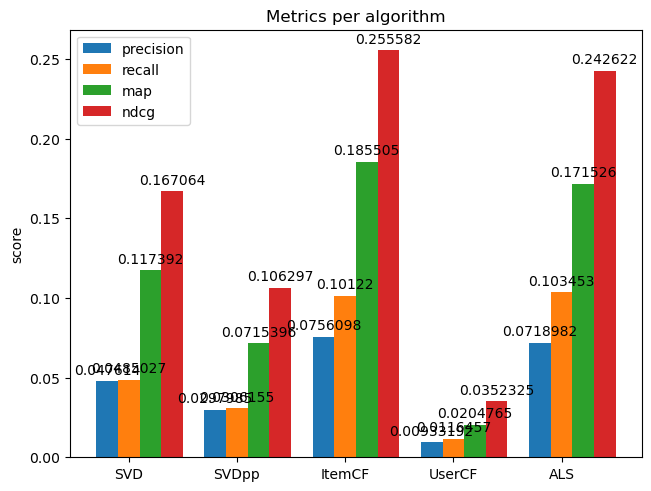

In [78]:
search_spaces = {
    'svd': svd_search,
    'svdpp': svdpp_search,
    'item_cf': item_cf_search,
    'user_cf': user_cf_search,
    'als': als_search
}

test_run5, details = run_experiment_chrono(df_data, search_spaces = search_spaces, save=True, experiment_name='test_run2', split=[0.8, 0.1, 0.1], task='ranking', samples=40, tune=True)
test_figures5 = model_results_chrono(test_run5)

In [79]:
day_40 = df_data['time'].min() + 86400 * 90

describe_set = df_data.loc[(df_data['time'] > day_40) & (df_data['time'] < day_40 + 86400)]['label'].describe()

describe_set

count    246.000000
mean       3.410569
std        1.033189
min        1.000000
25%        3.000000
50%        4.000000
75%        4.000000
max        5.000000
Name: label, dtype: float64

In [80]:
df_data['label'].value_counts()

4    34174
3    27145
5    21201
2    11370
1     6110
Name: label, dtype: int64

In [81]:
# for desc in ['count', 'mean', 'std', '75%']:
#   value_list = []
#   value_list2 = []
#   day_list = list(range(0, 210, 10))
#   for day in range(0, 210, 10):
#     day_m = df_data['time'].min() + 86400 * day
#     value_list.append(df_data.loc[(df_data['time'] > day_m) & (df_data['time'] < day_m + 86400)]['label'].describe()[desc])
#     value_list2.append(df_data.loc[(df_data['time'] <= day_m)]['label'].describe()[desc])

#   plt.figure(figsize=(10,6))

#   fig, ax = plt.subplots()

#   ax.plot(day_list, value_list, label=f'{desc}')
#   ax.plot(day_list, value_list2, label=f'time_before')

#   ax.set(xlabel='time (d)', ylabel=f'{desc}',
#         title=f'Comparison for {desc}')
#   ax.grid()
#   ax.set_xticks((range(10, 210, 20)))

#   # fig.savefig("test.png")
#   plt.legend()
#   plt.show()

In [82]:
# test_run4['40']

In [83]:
# train_data, eval_data, test_data = random_split(df_data, multi_ratios=[0.8, 0.1, 0.1])
# eval_data = DatasetPure.build_evalset(eval_data)
# train_data, data_info = DatasetPure.build_trainset(train)
# test_data = DatasetPure.build_testset(test)

# def reset_state(name):
#     tf.compat.v1.reset_default_graph()
#     print("\n", "=" * 30, name, "=" * 30)

# def create_results(algos, test_data, metrics):

#   results = {}

#   for algo in algos:
#     print(algo)
#     result = evaluate(model=algo, data=test_data, metrics=metrics, k=20)
#     results[algo.__class__.__name__] = result

#   return results

# metrics = [
#   "precision",
#   "recall",
#   "map",
#   "ndcg",
# ]

# reset_state("SVD")
# svd = SVD(
#     "ranking",
#     data_info,
#     embed_size=20,
#     n_epochs=50,
#     lr=0.001,
#     reg=0.0001,
# )

# svd.fit(
#     train_data,
#     verbose=0,
#     shuffle=False,
#     # eval_data=eval_data,
#     # metrics=metrics,
# )

# reset_state("SVD++")
# svdpp = SVDpp(
#     "ranking",
#     data_info,
#     loss_type="cross_entropy",
#     embed_size=50,
#     n_epochs=25,
#     lr=0.001,
#     reg=0.0001,
# )

# svdpp.fit(
#     train_data,
#     verbose=0,
#     # eval_data=eval_data,
#     # metrics=metrics,
# )

# reset_state("item_cf")
# item_cf = ItemCF(
#     task="ranking",
#     data_info=data_info,
#     k_sim=25,
#     sim_type="pearson",
# )

# item_cf.fit(
#     train_data,
#     verbose=0,
#     # eval_data=eval_data,
#     # metrics=metrics,
# )

# reset_state("user_cf")
# user_cf = UserCF(
#     task="ranking",
#     data_info=data_info,
#     k_sim=50,
#     sim_type="pearson",
# )

# user_cf.fit(
#     train_data,
#     verbose=0,
#     # eval_data=eval_data,
#     # metrics=metrics,
# )

# reset_state("ALS")
# als = ALS(
#     "ranking",
#     data_info,
#     embed_size=10,
#     n_epochs=200,
#     reg=5.0
# )

# als.fit(
#     train_data,
#     verbose=0,
#     # eval_data=eval_data,
#     # metrics=metrics,
# )

# algos = [svd, svdpp, als, item_cf, user_cf]

# result = create_results(algos, test_data, metrics)

# print(result)

In [84]:
# test_figures4 = model_results(test_run4, metrics_ranking, 2, model_time=True)

In [85]:
# for algorithm, algo_values in result.items():
#   for metric, values in algo_values.items():
#     offset = width * multiplier
#     rects = ax.bar(x + offset, measurement, width, label=attribute)
#     ax.bar_label(rects, padding=3)
#     multiplier += 1

# species = ("Adelie", "Chinstrap", "Gentoo")
# penguin_means = {
#     'Bill Depth': (18.35, 18.43, 14.98),
#     'Bill Length': (38.79, 48.83, 47.50),
#     'Flipper Length': (189.95, 195.82, 217.19),
# }

# x = np.arange(len(species))  # the label locations
# width = 0.25  # the width of the bars
# multiplier = 0

# fig, ax = plt.subplots(layout='constrained')

# for attribute, measurement in penguin_means.items():
#     offset = width * multiplier
#     rects = ax.bar(x + offset, measurement, width, label=attribute)
#     ax.bar_label(rects, padding=3)
#     multiplier += 1

# # Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_ylabel('Length (mm)')
# ax.set_title('Penguin attributes by species')
# ax.set_xticks(x + width, species)
# ax.legend(loc='upper left', ncols=3)
# ax.set_ylim(0, 250)

# plt.show()

In [86]:
# result

In [87]:
# svd.__class__.__name__

In [88]:
# algos = [svd, svdpp, item_cf, user_cf, als]

# results = {}

# for algo in algos:
#   accuracy = evaluate(model=algo, data=test_data, metrics=metrics)
#   results[algo.__class__.__name__] = accuracy

In [89]:
# print(results)

In [90]:
# tf.compat.v1.reset_default_graph()

# metrics = [
#   "precision",
#   "recall",
#   "map",
#   "ndcg",
# ]

# als = ALS(
#     "ranking",
#     data_info,
#     reg=5.0,
#     # embed_size=20,
#     # n_epochs=50,
#     # lr=0.001,
#     # reg=0.0001,
# )



# als.fit(
#     train_data,
#     verbose=0,
#     eval_data=eval_data,
#     metrics=metrics,
# )

# accuracy = evaluate(model=als, data=test_data, metrics=metrics)

In [91]:
# print(accuracy)